In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib
import math
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm import tqdm

import os
import datetime

start_time = datetime.datetime.now() 
print(start_time)

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

2024-06-28 17:50:58.687490


# Ensure you have a graphics card, otherwise the training time will be excessively long

In [2]:
device = torch.device("cuda:3")
print(torch.cuda.is_available())

True


# Set fixed random seed to ensure reproducible results

In [3]:
def set_seed(seed):
    # --- Set random seed
    random.seed(seed)
    np.random.seed(seed)
    # --- Ensure consistency in hash behavior
    os.environ["PYTHONHASHSEED"] = str(seed)
    # --- Setting the workspace configuration of cuBLAS
    """
    By setting the workspace configuration of cuBLAS, 
    specific workspace sizes and algorithm combinations are ensured when running deep learning models, 
    thereby maintaining consistency of results.
    """
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    # --- Make the random numbers generated on the CPU repeatable
    torch.manual_seed(seed)
    # --- Make the random numbers generated on a single GPU repeatable
    torch.cuda.manual_seed(seed)
    # --- Make the random numbers generated on multiple GPUs repeatable
    torch.cuda.manual_seed_all(seed)
    # --- Using deterministic algorithms ensures consistency and repeatability of calculation results across different runs
    torch.use_deterministic_algorithms(True)
    # --- Set the cuDNN backend to deterministic mode to ensure the use of deterministic algorithms
    """
    Certain operations (such as convolution) produce the same result in multiple runs.
    """
    torch.backends.cudnn.deterministic = True
    # --- Disable cuDNN using non deterministic algorithms
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False

set_seed(2024)

# Define a function for calculating accuracy

In [4]:
def get_clean_acc(model, data_loader, model_device):
    model.eval()
    correct = 0
    total = 0
    
    for data, labels in data_loader:
        data, labels = data.to(model_device), labels.to(model_device)
        with torch.no_grad():
            logits = model(data)
            prediction = torch.argmax(logits, 1)
            ground_truth = labels
            total += labels.size(0)
            correct += (prediction == ground_truth).sum().item()
            
    accuracy = correct / total
    print(f"Total:{total}  Correct:{correct}  CleanAccuracy:{accuracy:.4f}")
    return accuracy

# Define a function for training the model

In [5]:
def train(model_device,
          model,
          model_optimizer, 
          train_set, validate_set,
          epochs=200,
          classes=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
         ):
    train_loss_list = []
    validate_loss_list = []
    best_acc = -np.Inf
    
    # --- Define Scheduler
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=model_optimizer, milestones=[60, 120, 180], last_epoch=0 - 1)
    
    # --- Train
    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        validate_loss = 0.0
        model.train()
        count = 0
        for dataset_train, dataset_train_labels in train_set:
            count = count + 1
            dataset_train, dataset_train_labels = dataset_train.to(model_device), dataset_train_labels.to(model_device)
            
            logits = model(dataset_train)

            model_optimizer.zero_grad()
            loss = model.forward_loss(logits, dataset_train_labels)
            loss.backward()
            model_optimizer.step()
            
            train_loss += loss.item()
            torch.cuda.empty_cache()
        train_loss_list.append(train_loss / count)
        if scheduler is not None:
            scheduler.step()
        
        # --- Validate
        model.eval()
        count = 0
        for dataset_validate, dataset_validate_labels in validate_set:
            count = count + 1
            dataset_validate, dataset_validate_labels = dataset_validate.to(model_device), dataset_validate_labels.to(model_device)

            with torch.no_grad():
                logits = model(dataset_validate)
            loss = model.forward_loss(logits, dataset_validate_labels)

            validate_loss += loss.item()
            torch.cuda.empty_cache()
        validate_loss_list.append(validate_loss / count)
        
        # --- Show results
        model.eval()
        end_time = datetime.datetime.now()
        time = end_time - start_time
        print(f"Epoch:{epoch}\nTime:{time}\nLoss:{validate_loss / count}")           
        acc = get_clean_acc(model, validate_set, model_device)
        torch.cuda.empty_cache()
        
        # --- Save best model parameters
        if not os.path.exists("./best_params/mnist/wrn_28_10"):
            os.makedirs("./best_params/mnist/wrn_28_10")
        if acc >= best_acc:
            path = os.path.join("./best_params/mnist/wrn_28_10", f"wrn_28_10_params_{epoch}.pth")
            #torch.save(model.module.state_dict(), path)   # Enable during multi-GPUs training
            torch.save(model.state_dict(), path)           # Enable during single GPU training
            best_acc = acc
       
        # --- Visualize loss
        if epoch != 0:
            fig = plt.figure(figsize=(5, 5))
            x = range(0, len(validate_loss_list))
            y1 = train_loss_list
            y2 = validate_loss_list
            plt.plot(x, y1, 'bo-', label="Train Loss")
            plt.plot(x, y2, 'r--', label="Validate Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            if not os.path.exists("./best_params/mnist/wrn_28_10/loss_curve"):
                os.makedirs("./best_params/mnist/wrn_28_10/loss_curve")
            path = os.path.join("./best_params/mnist/wrn_28_10/loss_curve", f"loss_curve_{epoch}.png")
            plt.savefig(path, bbox_inches='tight', dpi=500)
            plt.show()

            if not os.path.exists("./best_params/mnist/wrn_28_10/loss_list"):
                os.makedirs("./best_params/mnist/wrn_28_10/loss_list")
            path = os.path.join("./best_params/mnist/wrn_28_10/loss_list", f"train_loss_list.pth")
            torch.save(train_loss_list, path)
            path = os.path.join("./best_params/mnist/wrn_28_10/loss_list", f"validate_loss_list.pth")
            torch.save(validate_loss_list, path)

# Load the dataset

In [6]:
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4, padding_mode="edge"),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_set = torchvision.datasets.MNIST(root="./data",
                                       train=True,
                                       transform=transform_train,
                                       download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1)

test_set = torchvision.datasets.MNIST(root="./data",
                                      train=False,
                                      transform=transform_test,
                                      download=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=1)
 
print("size=", len(train_loader))
print("size=", len(test_loader))

size= 1875
size= 313


# Load the model

In [7]:
from model_zoo.wide_resnet import wideresnet_28_10_mnist
net = wideresnet_28_10_mnist()
net = net.to(device)

# Define Optimizer

In [8]:
optimizer = torch.optim.SGD(params=net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)

# Begin to train

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

Epoch:0
Time:0:07:02.084723
Loss:0.07628859397427093


  0%|▍                                                                             | 1/200 [07:27<24:42:53, 447.10s/it]

Total:10000  Correct:9774  CleanAccuracy:0.9774
Epoch:1
Time:0:14:20.954982
Loss:0.2083158766993652
Total:10000  Correct:9336  CleanAccuracy:0.9336


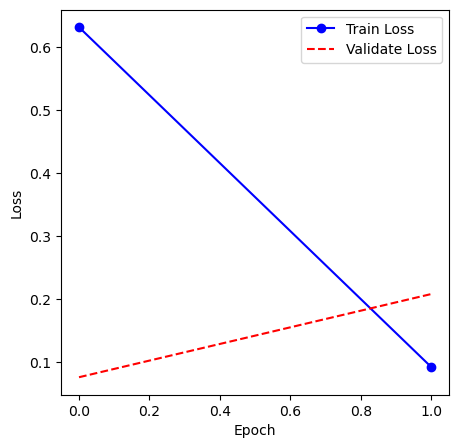

  1%|▊                                                                             | 2/200 [14:50<24:27:35, 444.72s/it]

Epoch:2
Time:0:21:42.603853
Loss:0.06031249744944816
Total:10000  Correct:9818  CleanAccuracy:0.9818


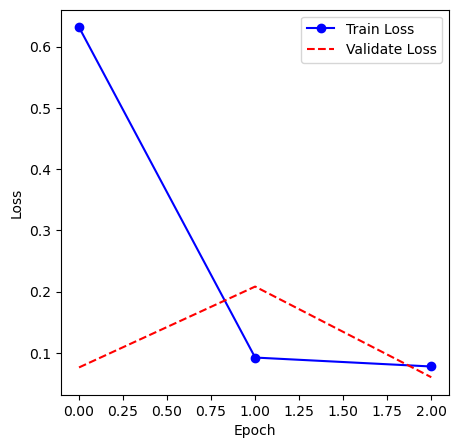

  2%|█▏                                                                            | 3/200 [22:11<24:15:31, 443.31s/it]

Epoch:3
Time:0:29:03.866359
Loss:0.059008327254001944
Total:10000  Correct:9835  CleanAccuracy:0.9835


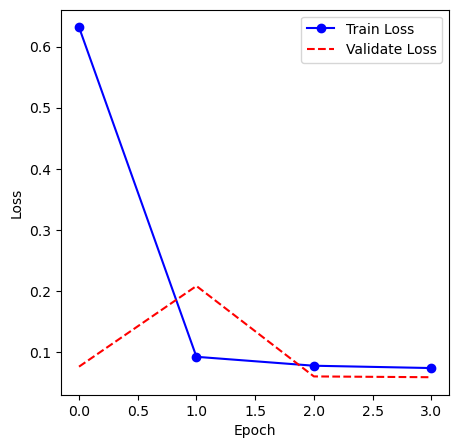

  2%|█▌                                                                            | 4/200 [29:32<24:04:23, 442.16s/it]

Epoch:4
Time:0:36:28.956872
Loss:0.07821853297387664
Total:10000  Correct:9765  CleanAccuracy:0.9765


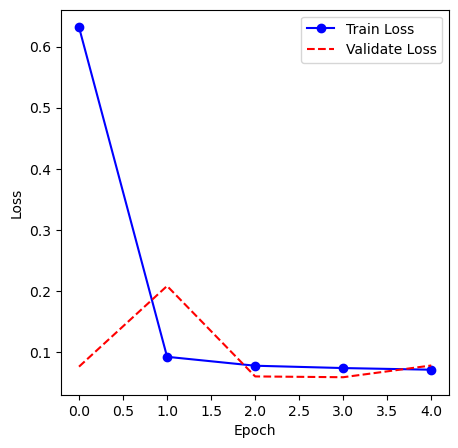

  2%|█▉                                                                            | 5/200 [36:54<23:57:00, 442.16s/it]

Epoch:5
Time:0:43:51.079469
Loss:0.09678377393043984
Total:10000  Correct:9737  CleanAccuracy:0.9737


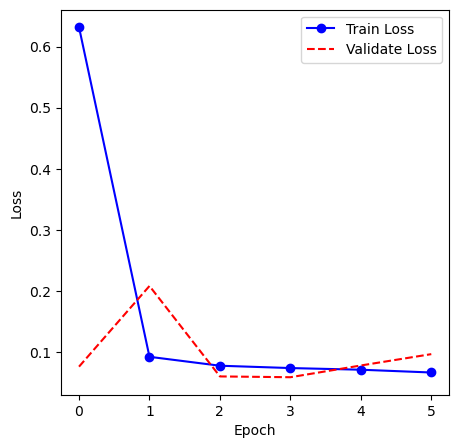

  3%|██▎                                                                           | 6/200 [44:18<23:52:04, 442.91s/it]

Epoch:6
Time:0:51:23.292882
Loss:0.10325640237060027
Total:10000  Correct:9676  CleanAccuracy:0.9676


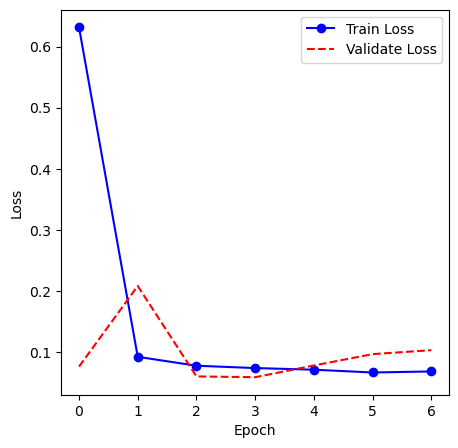

  4%|██▋                                                                           | 7/200 [51:49<23:52:46, 445.42s/it]

Epoch:7
Time:0:58:56.644140
Loss:0.06220322902115008
Total:10000  Correct:9836  CleanAccuracy:0.9836


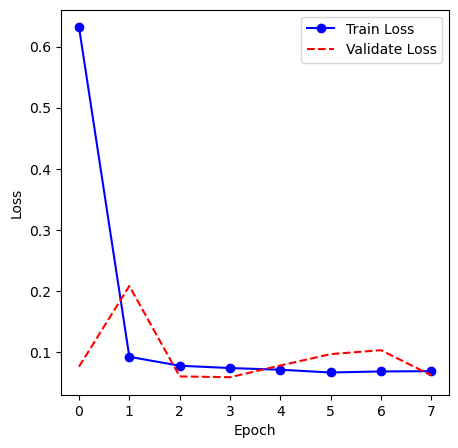

  4%|███                                                                           | 8/200 [59:23<23:53:53, 448.09s/it]

Epoch:8
Time:1:06:25.873013
Loss:0.0436544106248915
Total:10000  Correct:9858  CleanAccuracy:0.9858


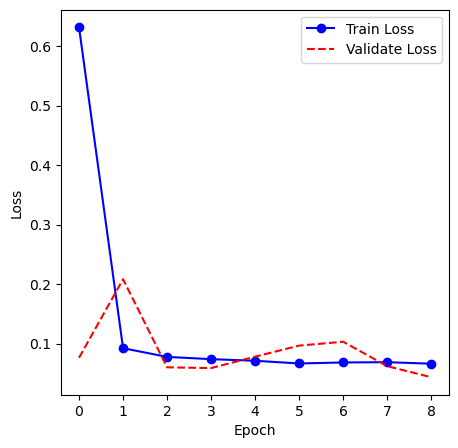

  4%|███▍                                                                        | 9/200 [1:06:52<23:47:55, 448.56s/it]

Epoch:9
Time:1:13:59.335109
Loss:0.03555473714996056
Total:10000  Correct:9886  CleanAccuracy:0.9886


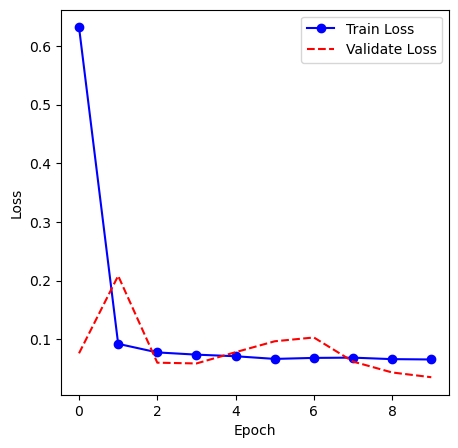

  5%|███▊                                                                       | 10/200 [1:14:26<23:45:41, 450.22s/it]

Epoch:10
Time:1:21:37.617892
Loss:0.05090982645445804
Total:10000  Correct:9855  CleanAccuracy:0.9855


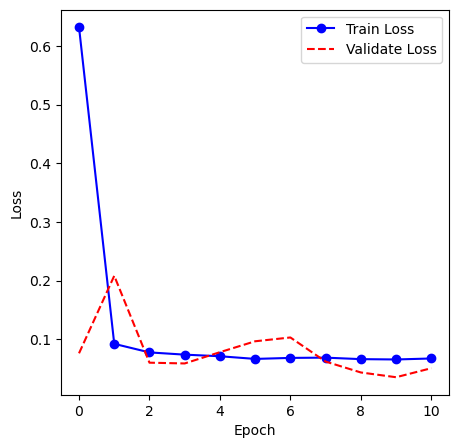

  6%|████▏                                                                      | 11/200 [1:22:04<23:45:49, 452.64s/it]

Epoch:11
Time:1:29:14.339343
Loss:0.048325804484890586
Total:10000  Correct:9873  CleanAccuracy:0.9873


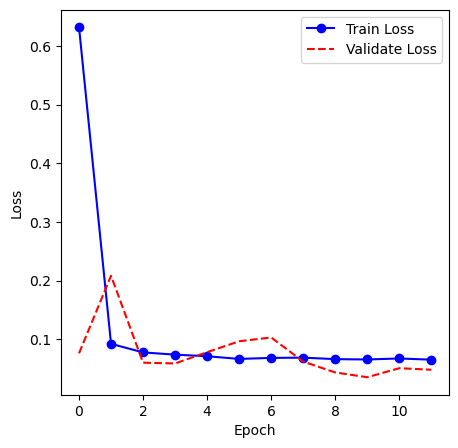

  6%|████▌                                                                      | 12/200 [1:29:39<23:40:30, 453.36s/it]

Epoch:12
Time:1:36:48.773901
Loss:0.03532450317414276
Total:10000  Correct:9894  CleanAccuracy:0.9894


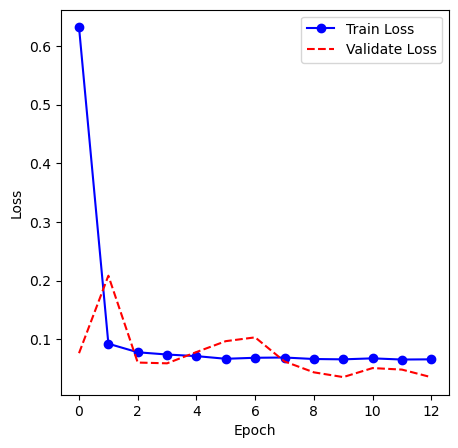

  6%|████▉                                                                      | 13/200 [1:37:16<23:36:02, 454.35s/it]

Epoch:13
Time:1:44:26.857827
Loss:0.05343624260610367
Total:10000  Correct:9824  CleanAccuracy:0.9824


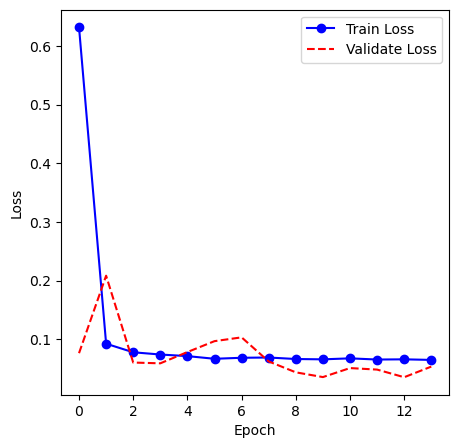

  7%|█████▎                                                                     | 14/200 [1:44:54<23:31:41, 455.38s/it]

Epoch:14
Time:1:52:04.573153
Loss:0.04655624789476581
Total:10000  Correct:9857  CleanAccuracy:0.9857


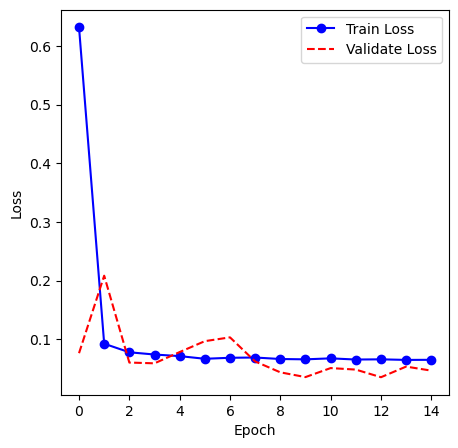

  8%|█████▋                                                                     | 15/200 [1:52:32<23:26:57, 456.31s/it]

Epoch:15
Time:1:59:42.653101
Loss:0.05070225427051063
Total:10000  Correct:9840  CleanAccuracy:0.9840


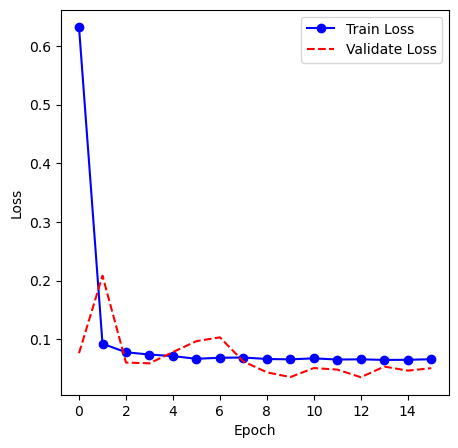

  8%|██████                                                                     | 16/200 [2:00:09<23:19:55, 456.50s/it]

Epoch:16
Time:2:07:19.418835
Loss:0.08357243839232549
Total:10000  Correct:9739  CleanAccuracy:0.9739


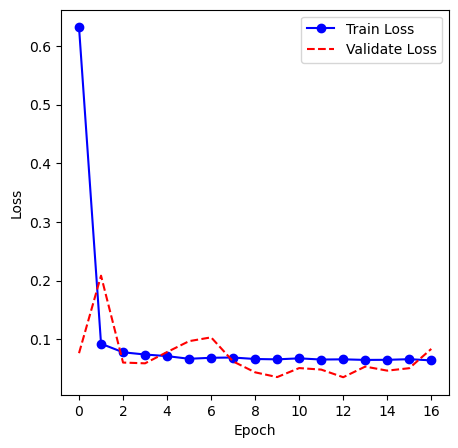

  8%|██████▍                                                                    | 17/200 [2:07:44<23:11:14, 456.14s/it]

Epoch:17
Time:2:14:56.831122
Loss:0.10007696561890984
Total:10000  Correct:9657  CleanAccuracy:0.9657


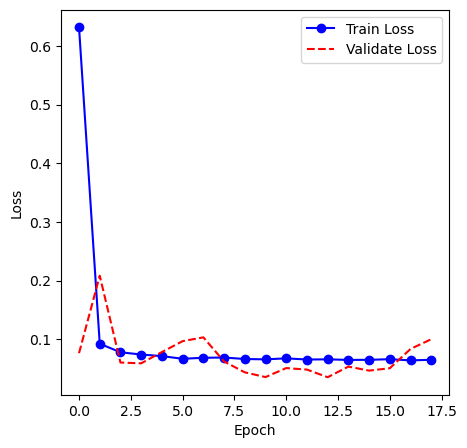

  9%|██████▊                                                                    | 18/200 [2:15:18<23:01:46, 455.53s/it]

Epoch:18
Time:2:22:27.230451
Loss:0.0749515780410841
Total:10000  Correct:9763  CleanAccuracy:0.9763


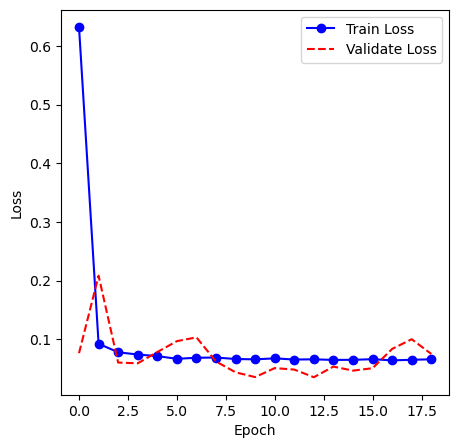

 10%|███████▏                                                                   | 19/200 [2:22:51<22:51:10, 454.53s/it]

Epoch:19
Time:2:29:59.852755
Loss:0.0632965164310217
Total:10000  Correct:9792  CleanAccuracy:0.9792


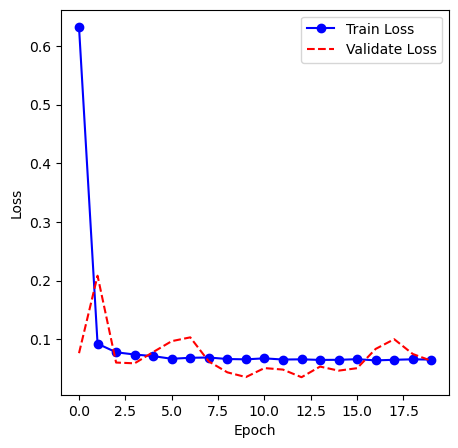

 10%|███████▌                                                                   | 20/200 [2:30:26<22:44:06, 454.70s/it]

Epoch:20
Time:2:37:34.572551
Loss:0.09296821263327171
Total:10000  Correct:9754  CleanAccuracy:0.9754


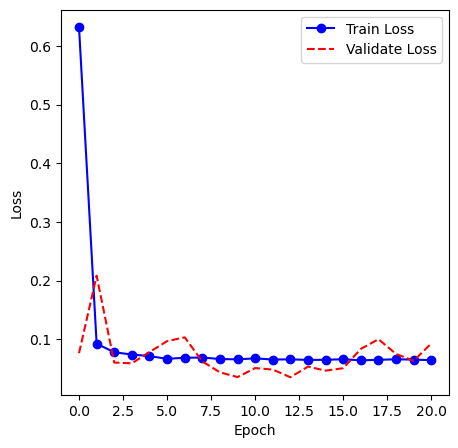

 10%|███████▉                                                                   | 21/200 [2:37:59<22:35:14, 454.27s/it]

Epoch:21
Time:2:45:01.410283
Loss:0.07299837798779137
Total:10000  Correct:9776  CleanAccuracy:0.9776


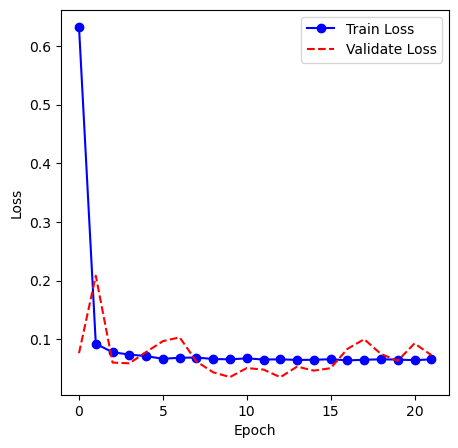

 11%|████████▎                                                                  | 22/200 [2:45:34<22:27:51, 454.34s/it]

Epoch:22
Time:2:52:35.308080
Loss:0.15024372943849584
Total:10000  Correct:9532  CleanAccuracy:0.9532


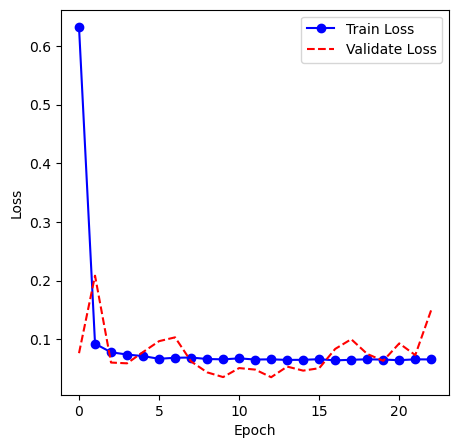

 12%|████████▋                                                                  | 23/200 [2:52:59<22:12:34, 451.72s/it]

Epoch:23
Time:3:00:08.717451
Loss:0.10450975861070833
Total:10000  Correct:9691  CleanAccuracy:0.9691


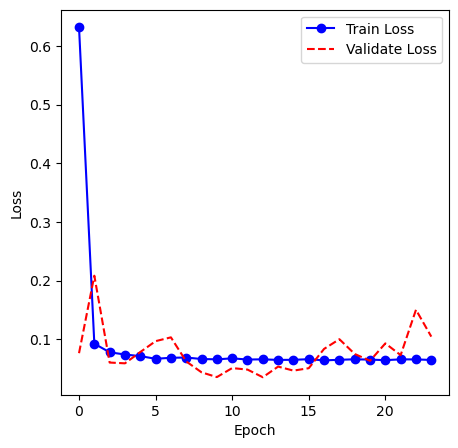

 12%|█████████                                                                  | 24/200 [3:00:33<22:06:43, 452.30s/it]

Epoch:24
Time:3:07:35.606189
Loss:0.0658640937354139
Total:10000  Correct:9794  CleanAccuracy:0.9794


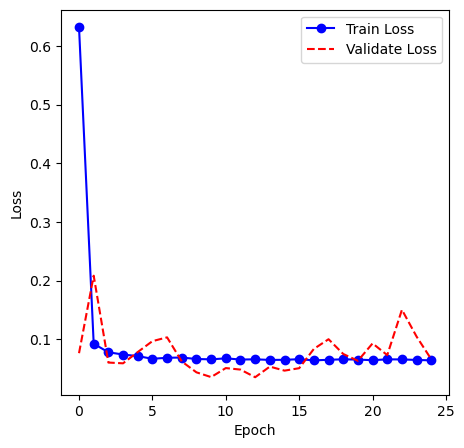

 12%|█████████▍                                                                 | 25/200 [3:08:02<21:56:14, 451.29s/it]

Epoch:25
Time:3:15:04.777774
Loss:0.16998214984996826
Total:10000  Correct:9515  CleanAccuracy:0.9515


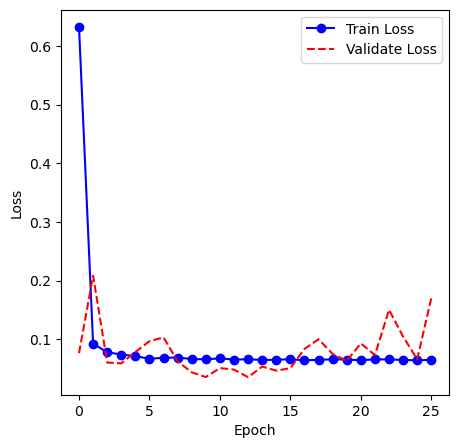

 13%|█████████▊                                                                 | 26/200 [3:15:31<21:46:58, 450.68s/it]

Epoch:26
Time:3:22:34.294786
Loss:0.08700331892206753
Total:10000  Correct:9745  CleanAccuracy:0.9745


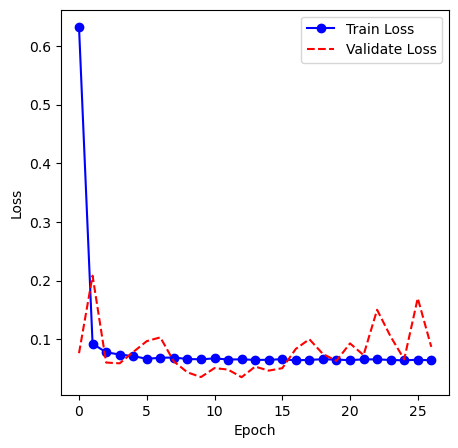

 14%|██████████▏                                                                | 27/200 [3:23:01<21:38:53, 450.48s/it]

Epoch:27
Time:3:30:08.016030
Loss:0.06207877238349507
Total:10000  Correct:9820  CleanAccuracy:0.9820


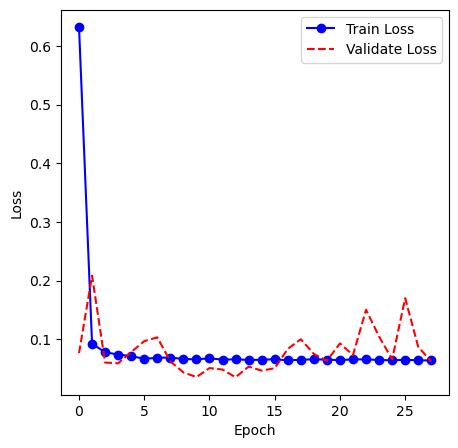

 14%|██████████▌                                                                | 28/200 [3:30:36<21:35:24, 451.89s/it]

Epoch:28
Time:3:37:44.020143
Loss:0.14308004434884022
Total:10000  Correct:9542  CleanAccuracy:0.9542


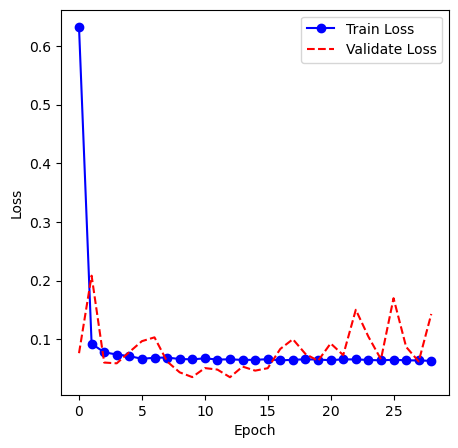

 14%|██████████▉                                                                | 29/200 [3:38:13<21:32:12, 453.40s/it]

Epoch:29
Time:3:45:17.213693
Loss:0.08094043104787366
Total:10000  Correct:9743  CleanAccuracy:0.9743


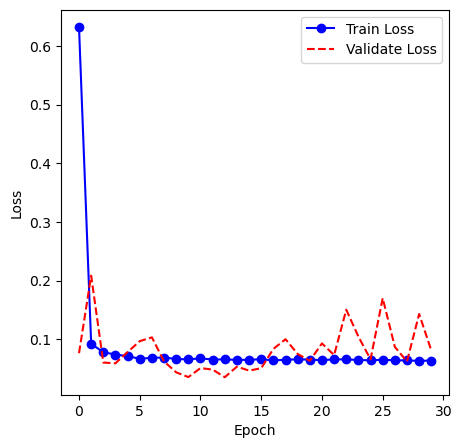

 15%|███████████▎                                                               | 30/200 [3:45:48<21:25:30, 453.71s/it]

Epoch:30
Time:3:52:56.923359
Loss:0.1709982831025133
Total:10000  Correct:9493  CleanAccuracy:0.9493


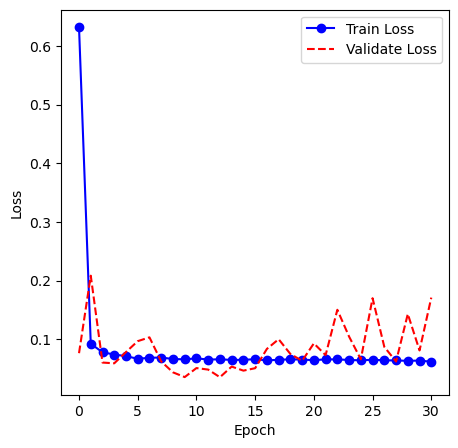

 16%|███████████▋                                                               | 31/200 [3:53:19<21:15:55, 452.99s/it]

Epoch:31
Time:4:00:24.161401
Loss:0.48963643241518984
Total:10000  Correct:8448  CleanAccuracy:0.8448


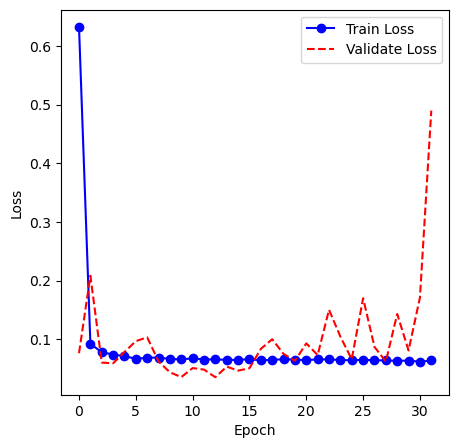

 16%|████████████                                                               | 32/200 [4:00:53<21:09:10, 453.28s/it]

Epoch:32
Time:4:07:59.670812
Loss:0.05549831840441378
Total:10000  Correct:9835  CleanAccuracy:0.9835


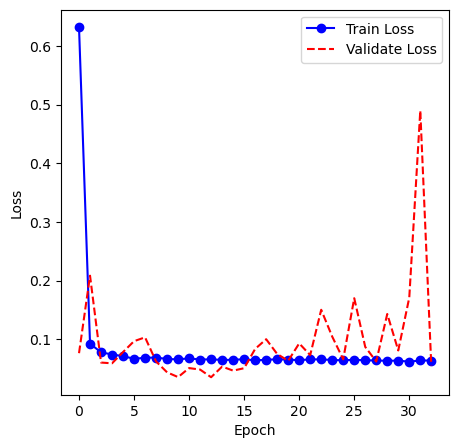

 16%|████████████▍                                                              | 33/200 [4:08:28<21:03:27, 453.94s/it]

Epoch:33
Time:4:15:36.024475
Loss:0.13796569080465435
Total:10000  Correct:9579  CleanAccuracy:0.9579


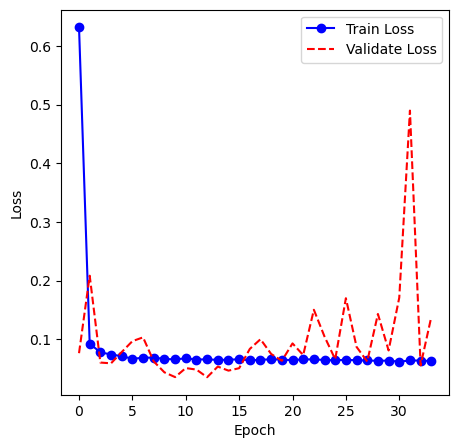

 17%|████████████▊                                                              | 34/200 [4:16:04<20:57:32, 454.53s/it]

Epoch:34
Time:4:23:13.857042
Loss:0.04117589523627485
Total:10000  Correct:9878  CleanAccuracy:0.9878


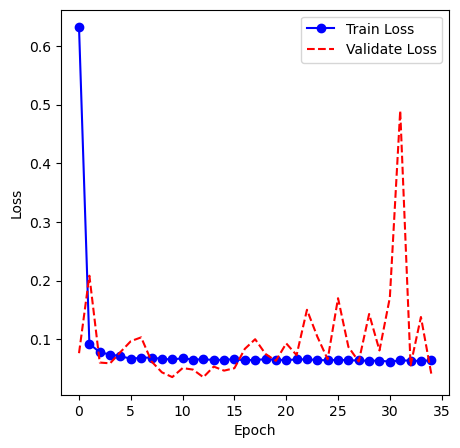

 18%|█████████████▏                                                             | 35/200 [4:23:43<20:53:23, 455.78s/it]

Epoch:35
Time:4:30:52.507710
Loss:0.1108513484432246
Total:10000  Correct:9654  CleanAccuracy:0.9654


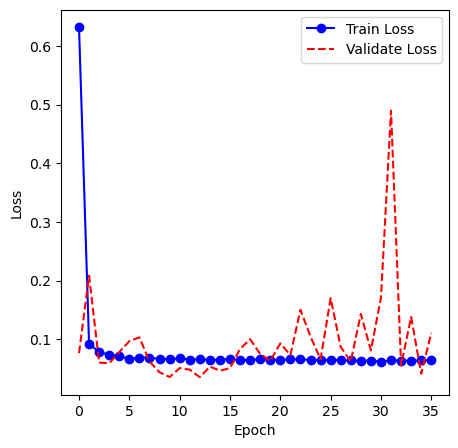

 18%|█████████████▌                                                             | 36/200 [4:31:18<20:45:11, 455.56s/it]

Epoch:36
Time:4:38:25.845327
Loss:0.05517983077463661
Total:10000  Correct:9838  CleanAccuracy:0.9838


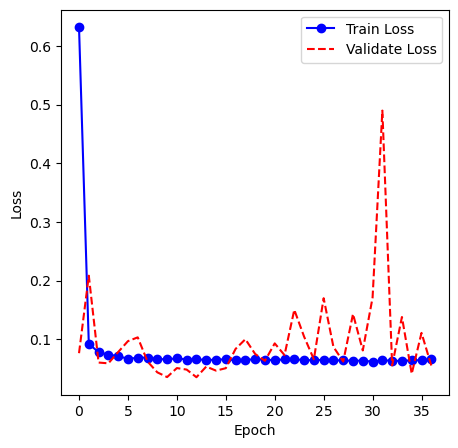

 18%|█████████████▉                                                             | 37/200 [4:38:53<20:37:20, 455.46s/it]

Epoch:37
Time:4:46:02.867123
Loss:0.052084055695759565
Total:10000  Correct:9851  CleanAccuracy:0.9851


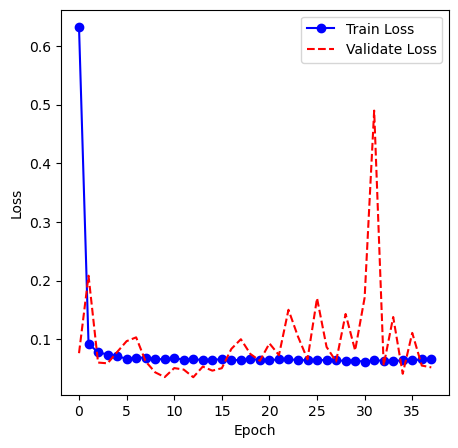

 19%|██████████████▎                                                            | 38/200 [4:46:31<20:31:36, 456.15s/it]

Epoch:38
Time:4:53:29.476118
Loss:0.04726773047622237
Total:10000  Correct:9863  CleanAccuracy:0.9863


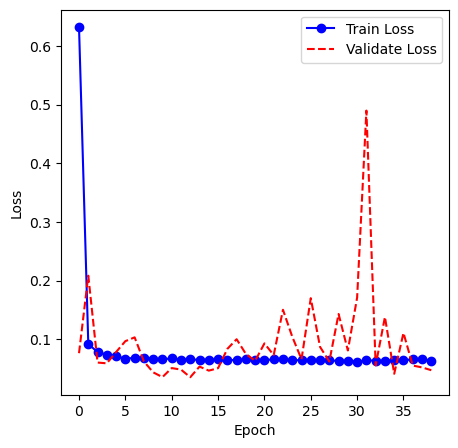

 20%|██████████████▋                                                            | 39/200 [4:53:59<20:17:06, 453.58s/it]

Epoch:39
Time:5:01:05.622370
Loss:0.05632396558414588
Total:10000  Correct:9817  CleanAccuracy:0.9817


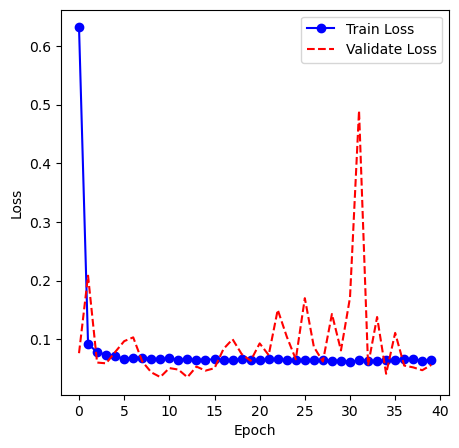

 20%|███████████████                                                            | 40/200 [5:01:29<20:07:02, 452.64s/it]

Epoch:40
Time:5:08:32.068204
Loss:0.045893706306887674
Total:10000  Correct:9852  CleanAccuracy:0.9852


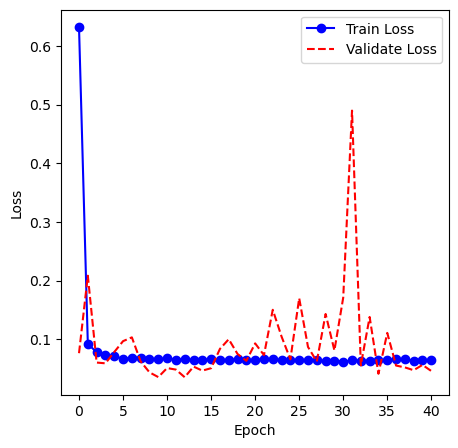

 20%|███████████████▎                                                           | 41/200 [5:09:07<20:03:32, 454.17s/it]

Epoch:41
Time:5:16:07.381481
Loss:0.055382961691461334
Total:10000  Correct:9837  CleanAccuracy:0.9837


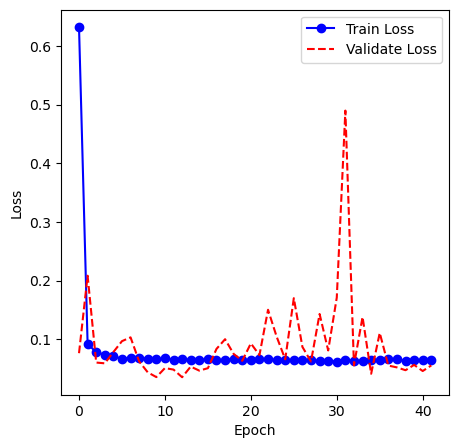

 21%|███████████████▊                                                           | 42/200 [5:16:37<19:52:45, 452.94s/it]

Epoch:42
Time:5:23:38.123244
Loss:0.060477001429609836
Total:10000  Correct:9819  CleanAccuracy:0.9819


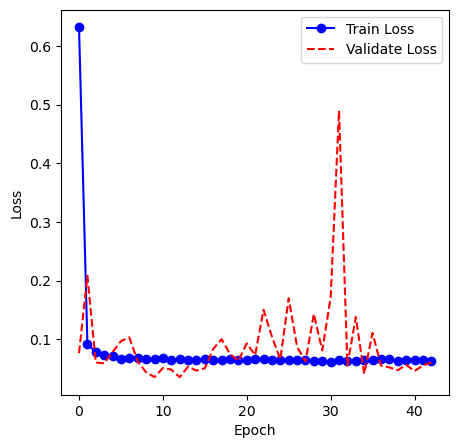

 22%|████████████████▏                                                          | 43/200 [5:24:00<19:37:19, 449.93s/it]

Epoch:43
Time:5:31:03.443454
Loss:0.045431351170785124
Total:10000  Correct:9848  CleanAccuracy:0.9848


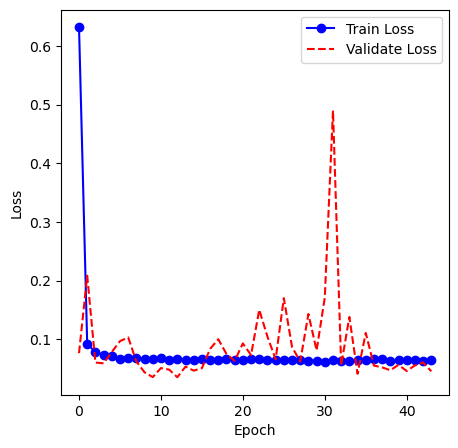

 22%|████████████████▌                                                          | 44/200 [5:31:32<19:32:01, 450.78s/it]

Epoch:44
Time:5:38:35.850501
Loss:0.23848822210043574
Total:10000  Correct:9226  CleanAccuracy:0.9226


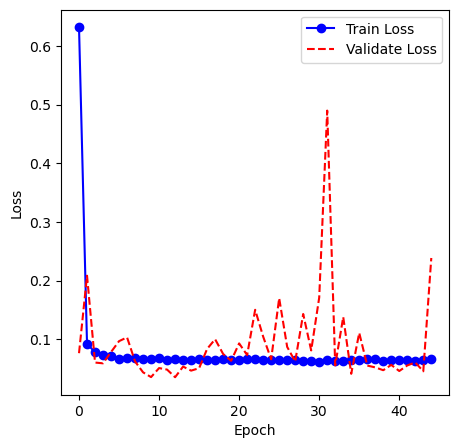

 22%|████████████████▉                                                          | 45/200 [5:39:03<19:24:42, 450.85s/it]

Epoch:45
Time:5:46:01.372030
Loss:0.07075391558018296
Total:10000  Correct:9790  CleanAccuracy:0.9790


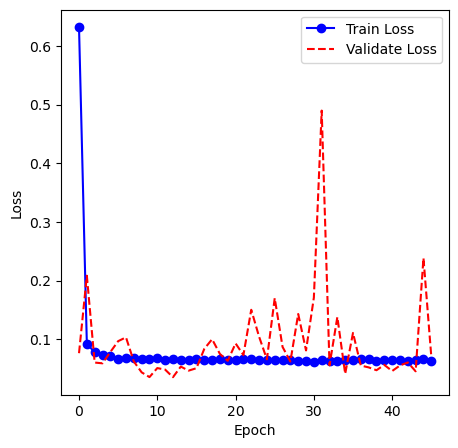

 23%|█████████████████▎                                                         | 46/200 [5:46:28<19:12:13, 448.92s/it]

Epoch:46
Time:5:53:35.583484
Loss:0.07708283405384263
Total:10000  Correct:9778  CleanAccuracy:0.9778


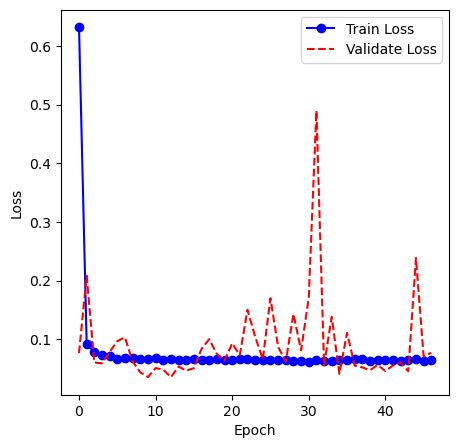

 24%|█████████████████▋                                                         | 47/200 [5:54:04<19:10:07, 451.03s/it]

Epoch:47
Time:6:01:14.693267
Loss:0.09188344265650823
Total:10000  Correct:9692  CleanAccuracy:0.9692


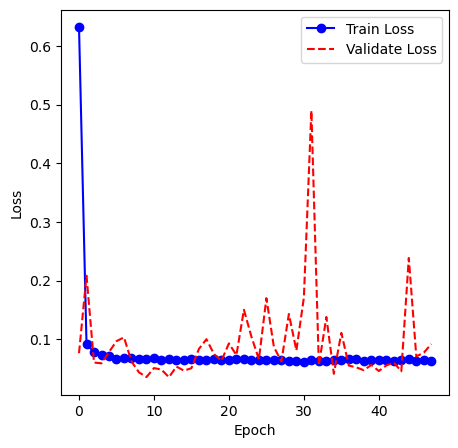

 24%|██████████████████                                                         | 48/200 [6:01:43<19:08:25, 453.32s/it]

Epoch:48
Time:6:08:45.226298
Loss:0.0525142579196622
Total:10000  Correct:9850  CleanAccuracy:0.9850


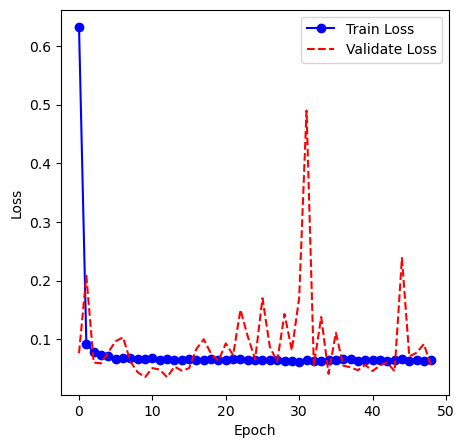

 24%|██████████████████▍                                                        | 49/200 [6:09:11<18:57:20, 451.92s/it]

Epoch:49
Time:6:16:18.887993
Loss:0.07790782194552621
Total:10000  Correct:9750  CleanAccuracy:0.9750


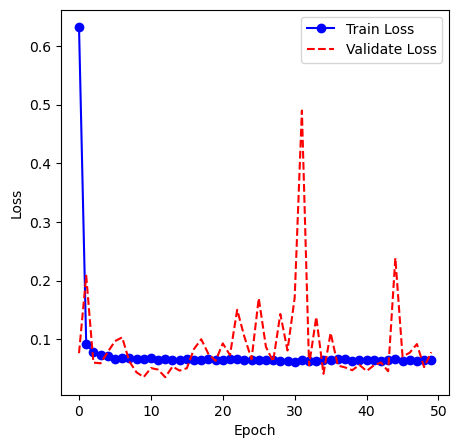

 25%|██████████████████▊                                                        | 50/200 [6:16:45<18:51:22, 452.55s/it]

Epoch:50
Time:6:23:49.323881
Loss:0.05737635857699373
Total:10000  Correct:9820  CleanAccuracy:0.9820


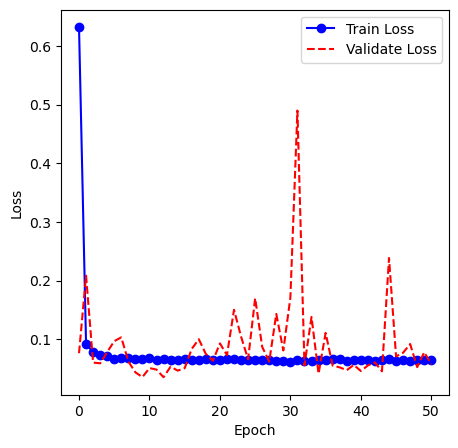

 26%|███████████████████▏                                                       | 51/200 [6:24:14<18:40:41, 451.28s/it]

Epoch:51
Time:6:31:19.469453
Loss:0.08705309883709224
Total:10000  Correct:9744  CleanAccuracy:0.9744


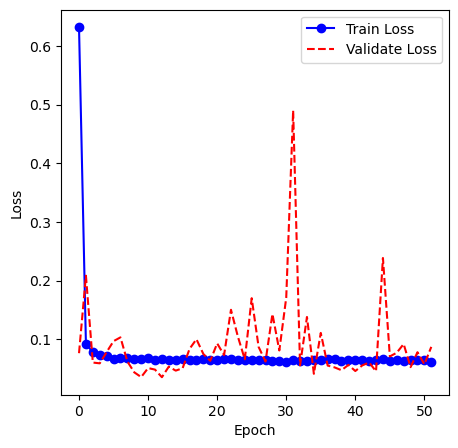

 26%|███████████████████▌                                                       | 52/200 [6:31:47<18:35:01, 452.04s/it]

Epoch:52
Time:6:38:52.822694
Loss:0.09726247602155783
Total:10000  Correct:9688  CleanAccuracy:0.9688


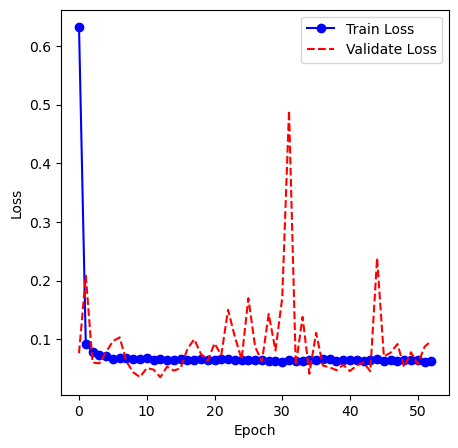

 26%|███████████████████▉                                                       | 53/200 [6:39:19<18:27:08, 451.89s/it]

Epoch:53
Time:6:46:27.875146
Loss:0.05044749187077388
Total:10000  Correct:9841  CleanAccuracy:0.9841


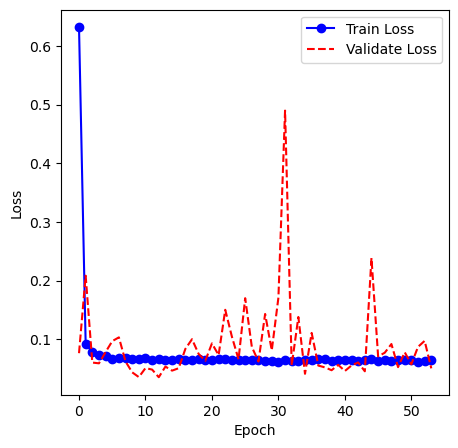

 27%|████████████████████▎                                                      | 54/200 [6:46:56<18:23:22, 453.44s/it]

Epoch:54
Time:6:54:05.412166
Loss:0.05062673651329137
Total:10000  Correct:9840  CleanAccuracy:0.9840


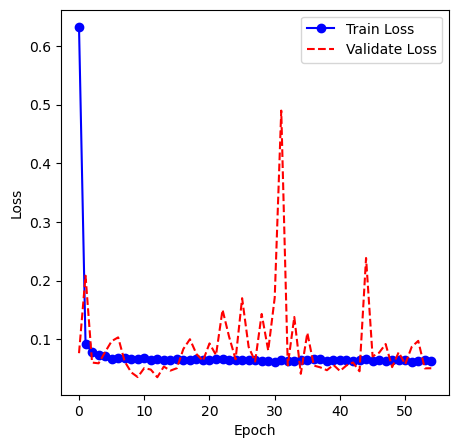

 28%|████████████████████▋                                                      | 55/200 [6:54:32<18:17:32, 454.15s/it]

Epoch:55
Time:7:01:35.500742
Loss:0.062252414936107545
Total:10000  Correct:9830  CleanAccuracy:0.9830


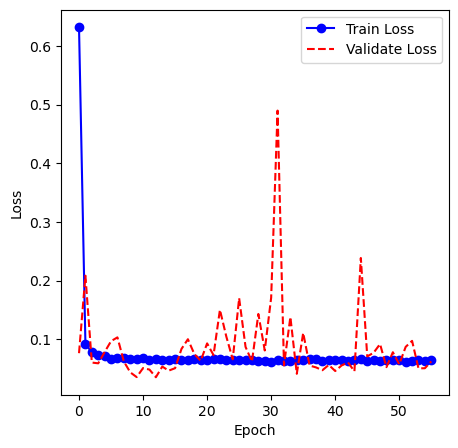

 28%|█████████████████████                                                      | 56/200 [7:02:03<18:07:57, 453.31s/it]

Epoch:56
Time:7:09:12.366862
Loss:0.07820177540263405
Total:10000  Correct:9770  CleanAccuracy:0.9770


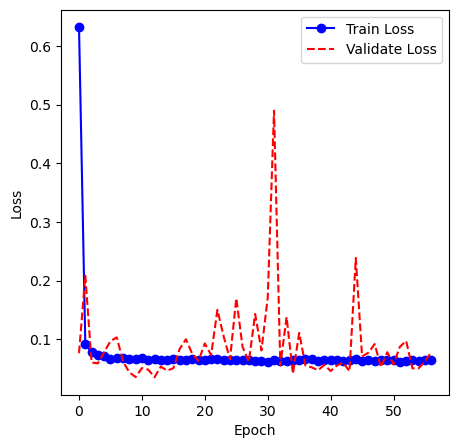

 28%|█████████████████████▎                                                     | 57/200 [7:09:40<18:02:41, 454.28s/it]

Epoch:57
Time:7:16:38.284266
Loss:0.06174820806822195
Total:10000  Correct:9843  CleanAccuracy:0.9843


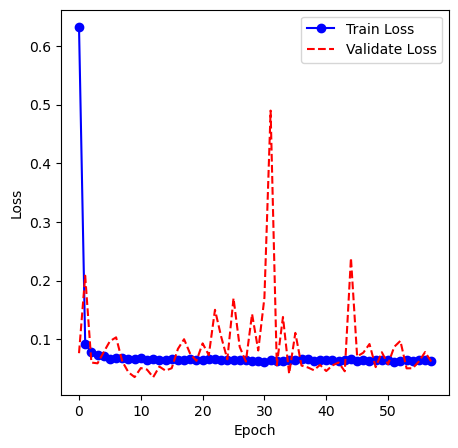

 29%|█████████████████████▊                                                     | 58/200 [7:17:09<17:51:52, 452.91s/it]

Epoch:58
Time:7:24:09.968597
Loss:0.051203391603052845
Total:10000  Correct:9842  CleanAccuracy:0.9842


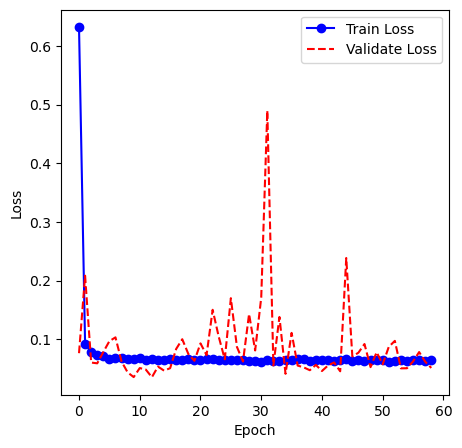

 30%|██████████████████████▏                                                    | 59/200 [7:24:35<17:39:22, 450.80s/it]

Epoch:59
Time:7:31:32.746013
Loss:0.04561462527875173
Total:10000  Correct:9872  CleanAccuracy:0.9872


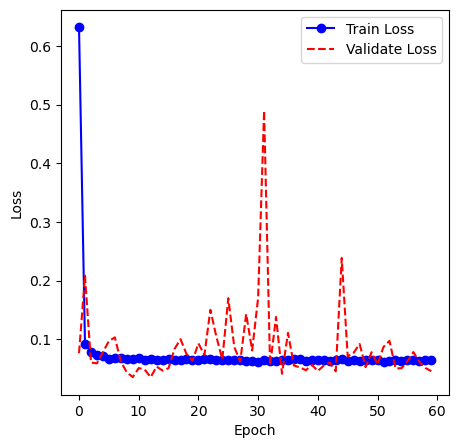

 30%|██████████████████████▌                                                    | 60/200 [7:32:01<17:28:43, 449.45s/it]

Epoch:60
Time:7:39:00.753756
Loss:0.012654174966569329
Total:10000  Correct:9961  CleanAccuracy:0.9961


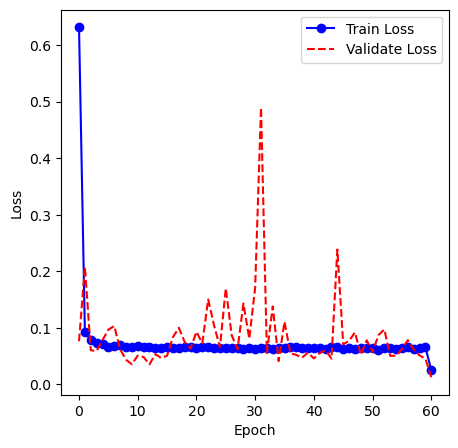

 30%|██████████████████████▉                                                    | 61/200 [7:39:25<17:17:10, 447.70s/it]

Epoch:61
Time:7:46:19.412397
Loss:0.011358616209789603
Total:10000  Correct:9960  CleanAccuracy:0.9960


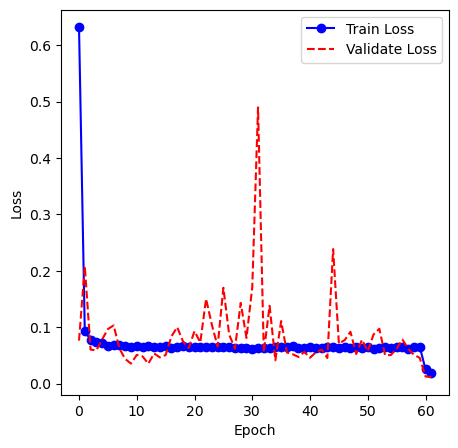

 31%|███████████████████████▎                                                   | 62/200 [7:46:49<17:06:56, 446.49s/it]

Epoch:62
Time:7:53:47.472116
Loss:0.01119637457204677
Total:10000  Correct:9965  CleanAccuracy:0.9965


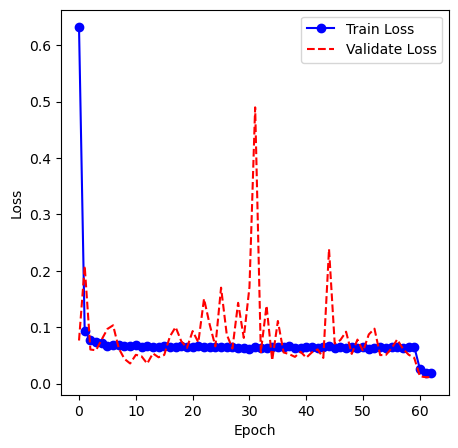

 32%|███████████████████████▋                                                   | 63/200 [7:54:08<16:54:43, 444.41s/it]

Epoch:63
Time:8:01:08.581809
Loss:0.013823426950984402
Total:10000  Correct:9953  CleanAccuracy:0.9953


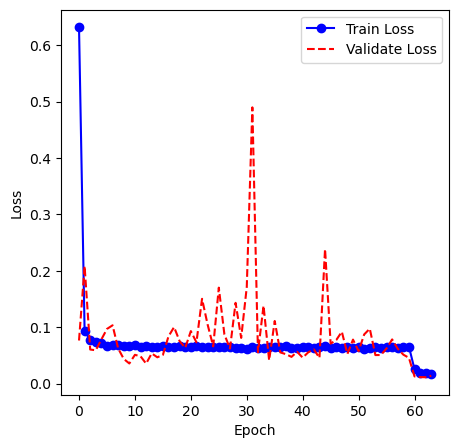

 32%|████████████████████████                                                   | 64/200 [8:01:36<16:49:30, 445.37s/it]

Epoch:64
Time:8:08:39.282647
Loss:0.013500868304089208
Total:10000  Correct:9957  CleanAccuracy:0.9957


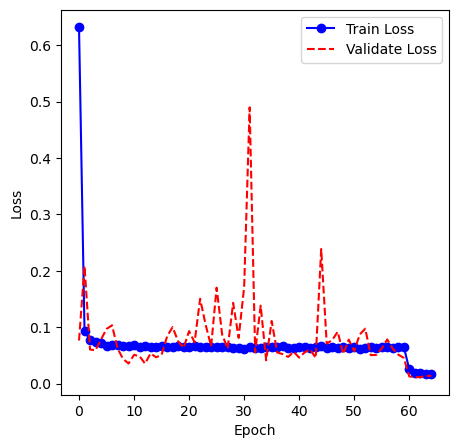

 32%|████████████████████████▍                                                  | 65/200 [8:09:09<16:46:57, 447.54s/it]

Epoch:65
Time:8:16:15.062757
Loss:0.015107910340694084
Total:10000  Correct:9953  CleanAccuracy:0.9953


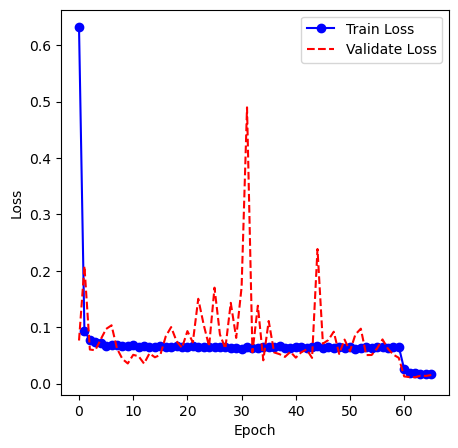

 33%|████████████████████████▊                                                  | 66/200 [8:16:42<16:43:41, 449.41s/it]

Epoch:66
Time:8:23:46.024096
Loss:0.012099788304165039
Total:10000  Correct:9966  CleanAccuracy:0.9966


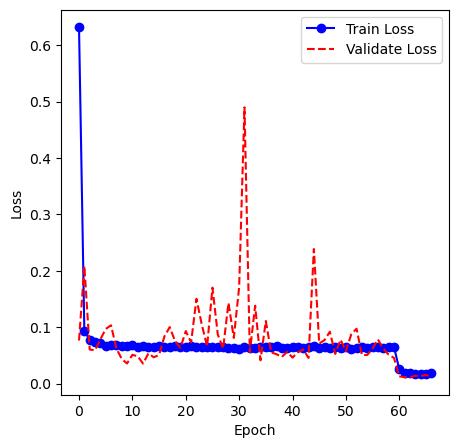

 34%|█████████████████████████▏                                                 | 67/200 [8:24:11<16:35:40, 449.18s/it]

Epoch:67
Time:8:31:17.808760
Loss:0.02266042521471692
Total:10000  Correct:9934  CleanAccuracy:0.9934


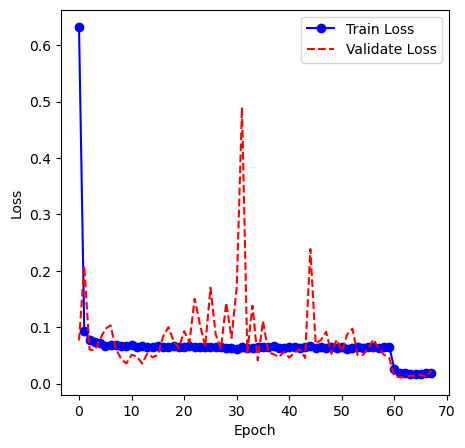

 34%|█████████████████████████▌                                                 | 68/200 [8:31:44<16:30:39, 450.30s/it]

Epoch:68
Time:8:38:47.353545
Loss:0.016768519919865523
Total:10000  Correct:9942  CleanAccuracy:0.9942


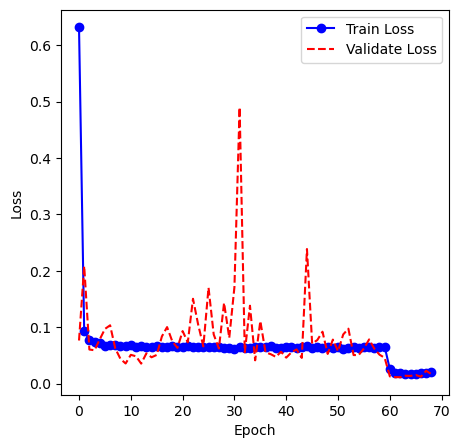

 34%|█████████████████████████▊                                                 | 69/200 [8:39:14<16:23:08, 450.29s/it]

Epoch:69
Time:8:46:19.087820
Loss:0.016612991647537836
Total:10000  Correct:9955  CleanAccuracy:0.9955


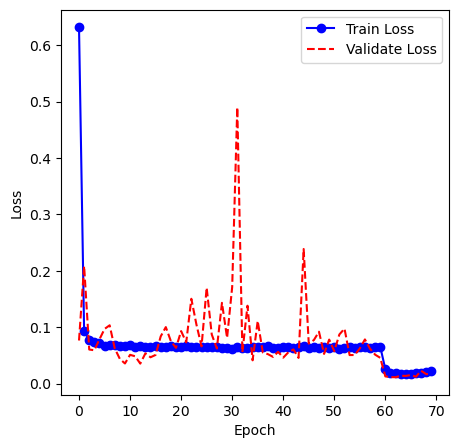

 35%|██████████████████████████▎                                                | 70/200 [8:46:49<16:18:37, 451.67s/it]

Epoch:70
Time:8:53:59.086600
Loss:0.02327901385991407
Total:10000  Correct:9931  CleanAccuracy:0.9931


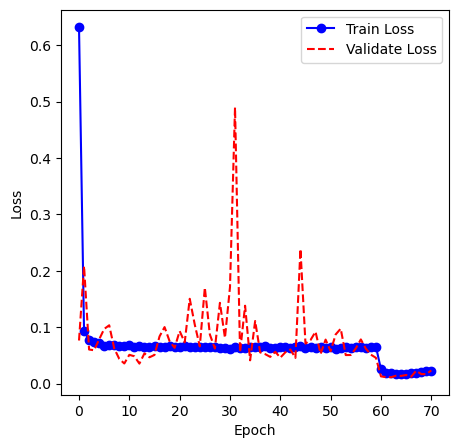

 36%|██████████████████████████▋                                                | 71/200 [8:54:25<16:14:04, 453.06s/it]

Epoch:71
Time:9:01:35.773136
Loss:0.017389489309488464
Total:10000  Correct:9938  CleanAccuracy:0.9938


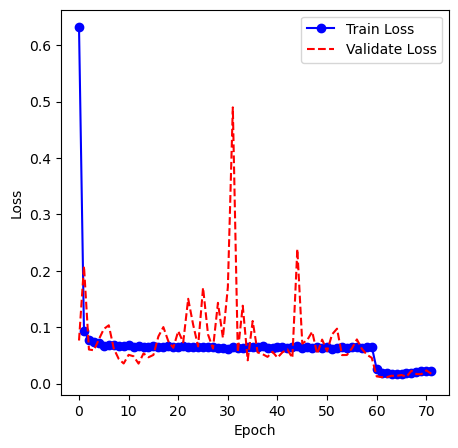

 36%|███████████████████████████                                                | 72/200 [9:02:03<16:09:31, 454.47s/it]

Epoch:72
Time:9:09:15.433650
Loss:0.016576000146417934
Total:10000  Correct:9945  CleanAccuracy:0.9945


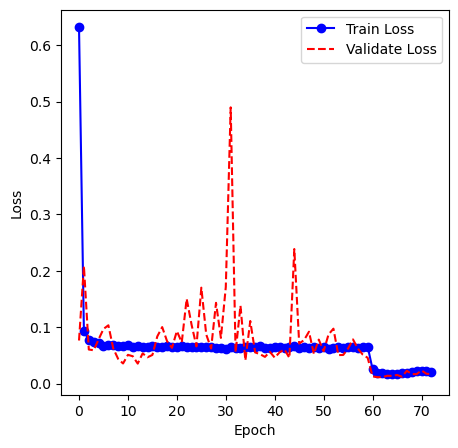

 36%|███████████████████████████▍                                               | 73/200 [9:09:40<16:03:30, 455.20s/it]

Epoch:73
Time:9:16:46.560318
Loss:0.029605627431684493
Total:10000  Correct:9905  CleanAccuracy:0.9905


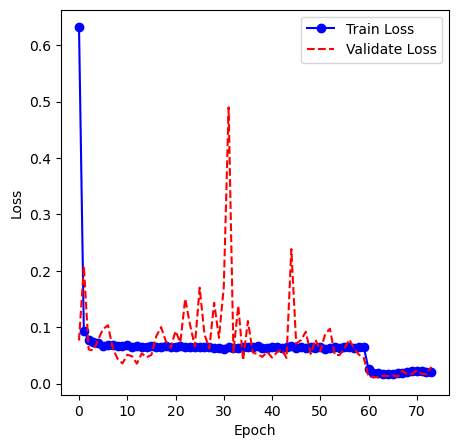

 37%|███████████████████████████▊                                               | 74/200 [9:17:09<15:51:56, 453.30s/it]

Epoch:74
Time:9:24:19.006506
Loss:0.02019372698111711
Total:10000  Correct:9936  CleanAccuracy:0.9936


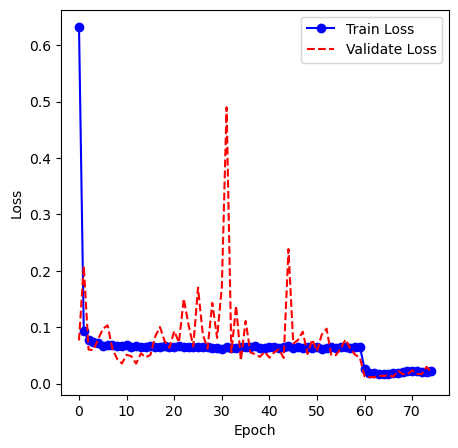

 38%|████████████████████████████▏                                              | 75/200 [9:24:46<15:46:49, 454.48s/it]

Epoch:75
Time:9:31:50.885801
Loss:0.019098118185244217
Total:10000  Correct:9940  CleanAccuracy:0.9940


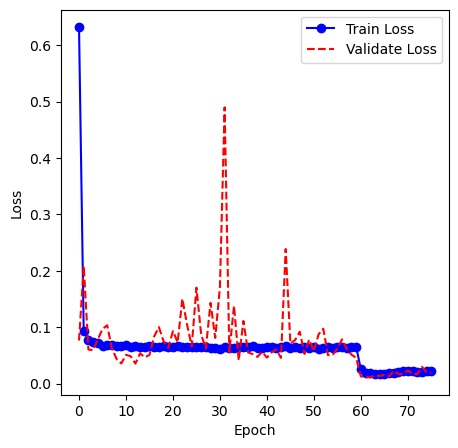

 38%|████████████████████████████▌                                              | 76/200 [9:32:18<15:37:41, 453.73s/it]

Epoch:76
Time:9:39:14.803396
Loss:0.03365124343455912
Total:10000  Correct:9896  CleanAccuracy:0.9896


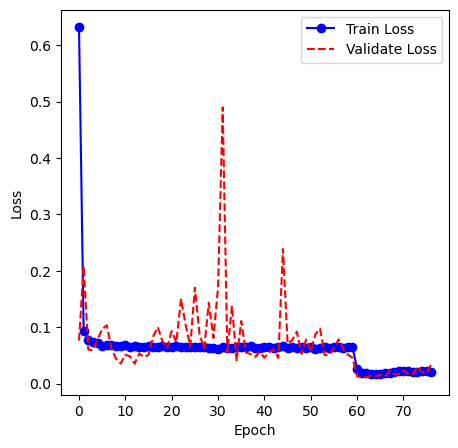

 38%|████████████████████████████▉                                              | 77/200 [9:39:42<15:24:09, 450.81s/it]

Epoch:77
Time:9:46:43.508142
Loss:0.024285018941522917
Total:10000  Correct:9932  CleanAccuracy:0.9932


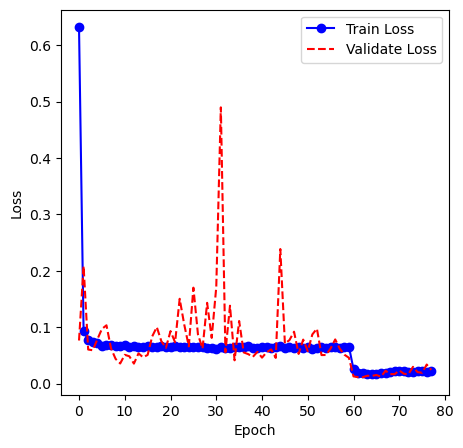

 39%|█████████████████████████████▎                                             | 78/200 [9:47:15<15:17:38, 451.30s/it]

Epoch:78
Time:9:54:14.210823
Loss:0.017761326087990213
Total:10000  Correct:9942  CleanAccuracy:0.9942


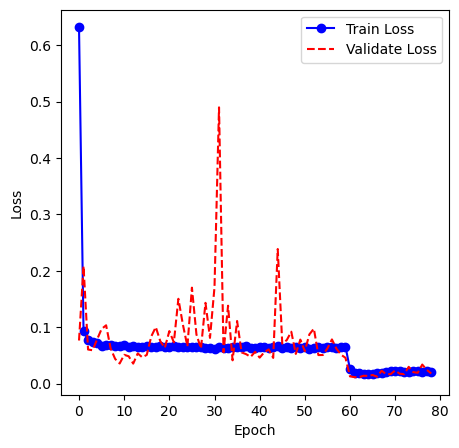

 40%|█████████████████████████████▋                                             | 79/200 [9:54:42<15:08:03, 450.28s/it]

Epoch:79
Time:10:01:44.660938
Loss:0.026081595028080745
Total:10000  Correct:9916  CleanAccuracy:0.9916


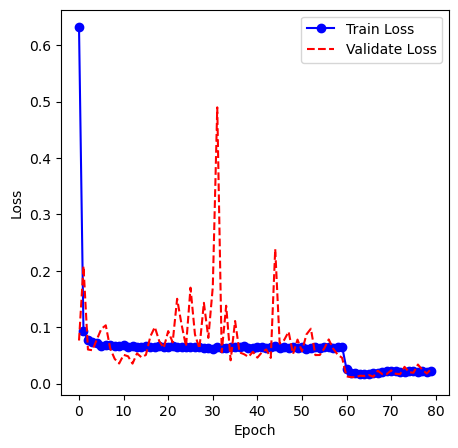

 40%|█████████████████████████████▌                                            | 80/200 [10:02:04<14:55:13, 447.61s/it]

Epoch:80
Time:10:09:09.186721
Loss:0.01522900409380587
Total:10000  Correct:9950  CleanAccuracy:0.9950


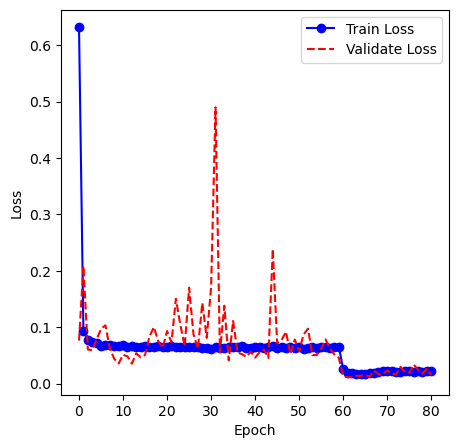

 40%|█████████████████████████████▉                                            | 81/200 [10:09:31<14:47:21, 447.41s/it]

Epoch:81
Time:10:16:32.941744
Loss:0.019592145889353665
Total:10000  Correct:9934  CleanAccuracy:0.9934


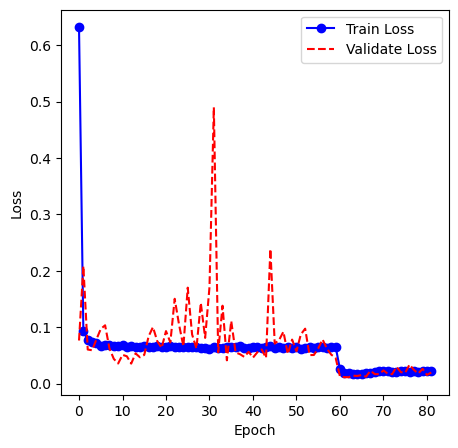

 41%|██████████████████████████████▎                                           | 82/200 [10:16:59<14:40:25, 447.68s/it]

Epoch:82
Time:10:24:03.194245
Loss:0.024215983208019685
Total:10000  Correct:9926  CleanAccuracy:0.9926


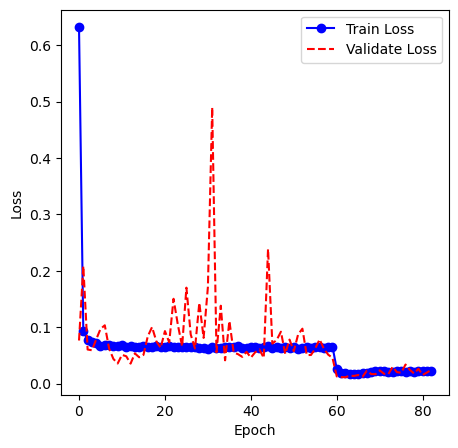

 42%|██████████████████████████████▋                                           | 83/200 [10:24:30<14:34:51, 448.64s/it]

Epoch:83
Time:10:31:40.466092
Loss:0.018379571739059408
Total:10000  Correct:9946  CleanAccuracy:0.9946


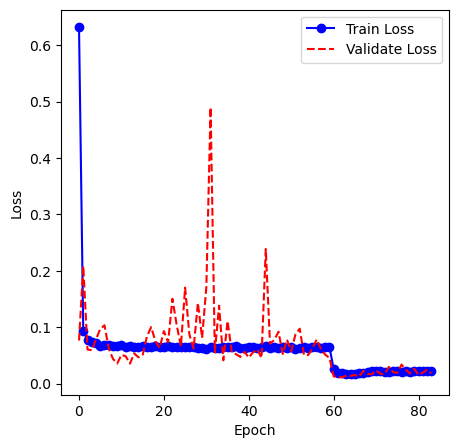

 42%|███████████████████████████████                                           | 84/200 [10:32:09<14:33:29, 451.81s/it]

Epoch:84
Time:10:39:12.353979
Loss:0.022226426565291408
Total:10000  Correct:9932  CleanAccuracy:0.9932


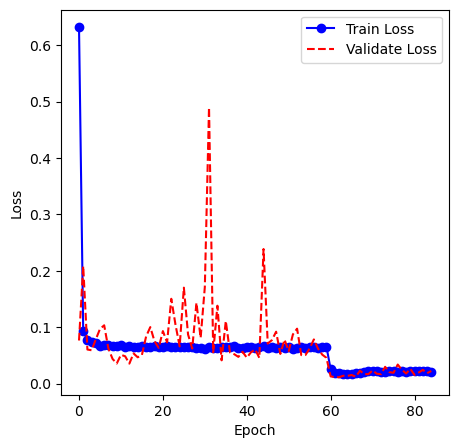

 42%|███████████████████████████████▍                                          | 85/200 [10:39:37<14:23:51, 450.71s/it]

Epoch:85
Time:10:46:45.467266
Loss:0.03362449295536136
Total:10000  Correct:9909  CleanAccuracy:0.9909


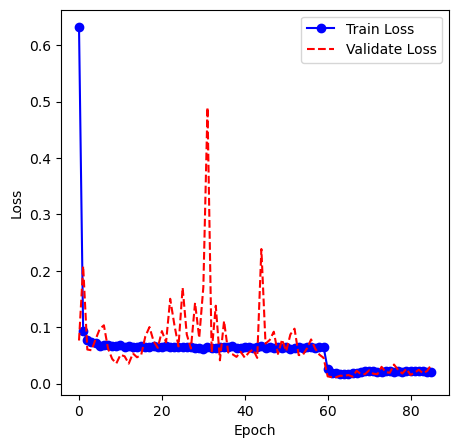

 43%|███████████████████████████████▊                                          | 86/200 [10:47:09<14:17:12, 451.16s/it]

Epoch:86
Time:10:54:14.213524
Loss:0.01931131603361774
Total:10000  Correct:9943  CleanAccuracy:0.9943


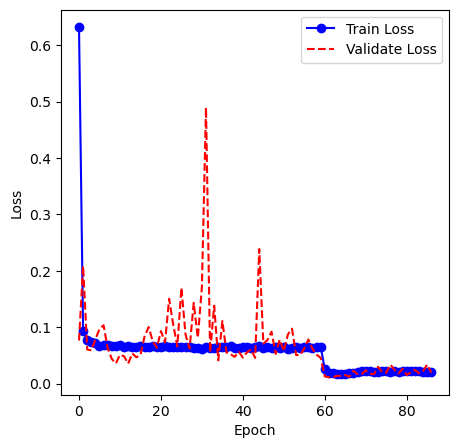

 44%|████████████████████████████████▏                                         | 87/200 [10:54:39<14:08:54, 450.75s/it]

Epoch:87
Time:11:01:48.175980
Loss:0.02083281055315972
Total:10000  Correct:9942  CleanAccuracy:0.9942


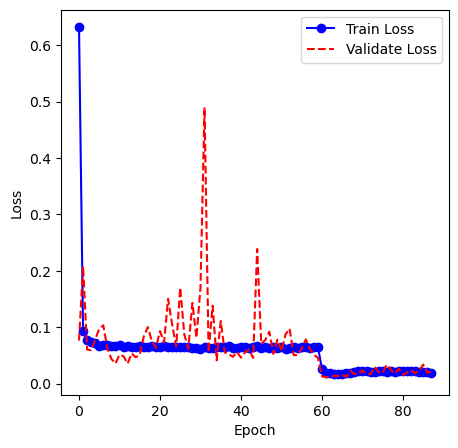

 44%|████████████████████████████████▌                                         | 88/200 [11:02:21<14:07:18, 453.92s/it]

Epoch:88
Time:11:09:28.974481
Loss:0.01720077261092891
Total:10000  Correct:9951  CleanAccuracy:0.9951


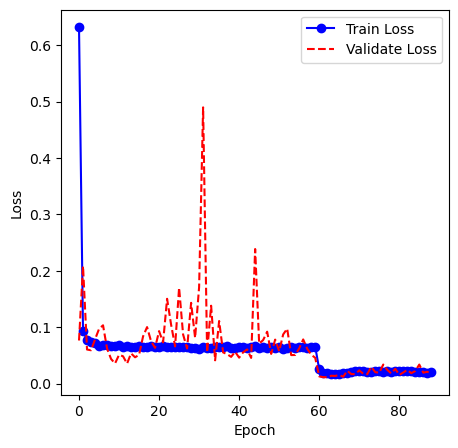

 44%|████████████████████████████████▉                                         | 89/200 [11:09:51<13:58:03, 453.01s/it]

Epoch:89
Time:11:16:59.895294
Loss:0.026322465145792336
Total:10000  Correct:9918  CleanAccuracy:0.9918


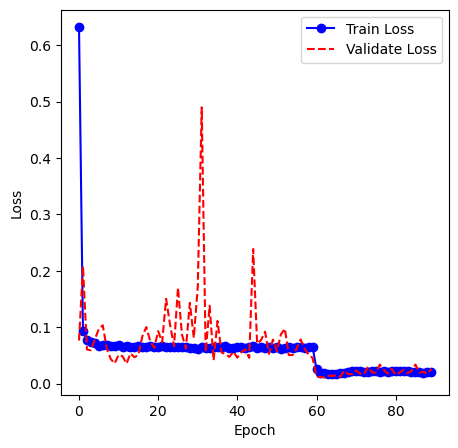

 45%|█████████████████████████████████▎                                        | 90/200 [11:17:26<13:51:18, 453.44s/it]

Epoch:90
Time:11:24:34.421625
Loss:0.021625180877879048
Total:10000  Correct:9934  CleanAccuracy:0.9934


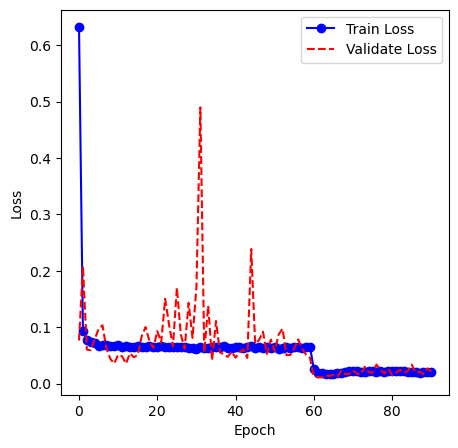

 46%|█████████████████████████████████▋                                        | 91/200 [11:25:01<13:44:37, 453.92s/it]

Epoch:91
Time:11:32:08.300859
Loss:0.023182438078889485
Total:10000  Correct:9932  CleanAccuracy:0.9932


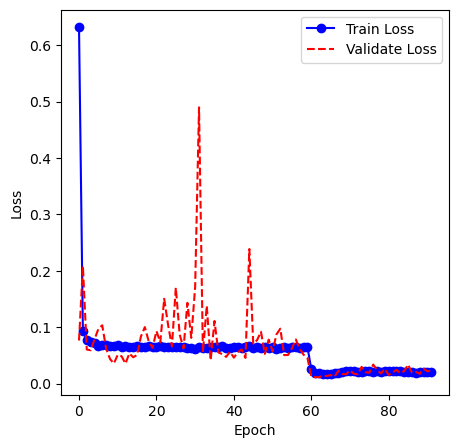

 46%|██████████████████████████████████                                        | 92/200 [11:32:32<13:35:18, 452.94s/it]

Epoch:92
Time:11:39:41.955122
Loss:0.020793371260617696
Total:10000  Correct:9937  CleanAccuracy:0.9937


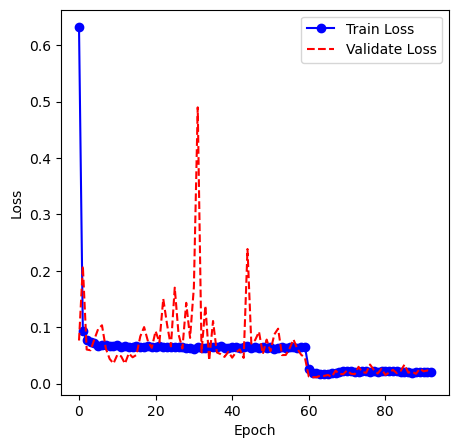

 46%|██████████████████████████████████▍                                       | 93/200 [11:40:09<13:30:07, 454.28s/it]

Epoch:93
Time:11:47:14.435386
Loss:0.018283042457726852
Total:10000  Correct:9944  CleanAccuracy:0.9944


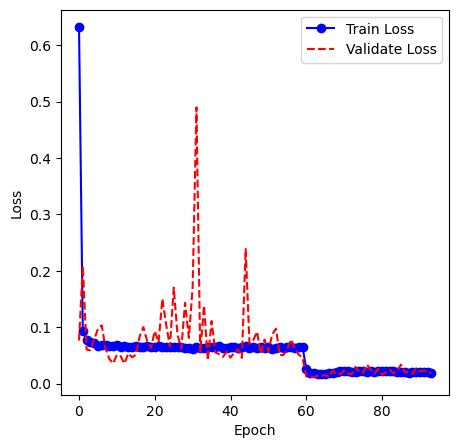

 47%|██████████████████████████████████▊                                       | 94/200 [11:47:47<13:24:44, 455.51s/it]

Epoch:94
Time:11:54:51.882399
Loss:0.018318075154874155
Total:10000  Correct:9944  CleanAccuracy:0.9944


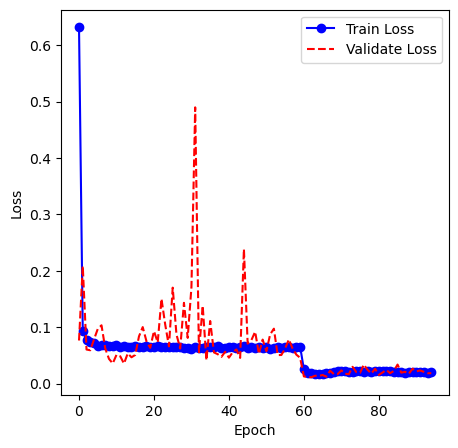

 48%|███████████████████████████████████▏                                      | 95/200 [11:55:17<13:14:06, 453.78s/it]

Epoch:95
Time:12:02:17.938581
Loss:0.026762563622271727
Total:10000  Correct:9914  CleanAccuracy:0.9914


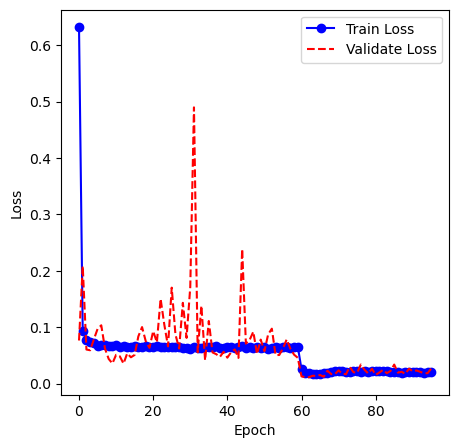

 48%|███████████████████████████████████▌                                      | 96/200 [12:02:47<13:04:26, 452.56s/it]

Epoch:96
Time:12:09:45.062905
Loss:0.019339096817749958
Total:10000  Correct:9939  CleanAccuracy:0.9939


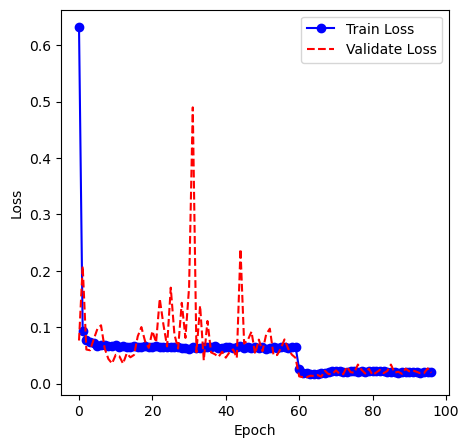

 48%|███████████████████████████████████▉                                      | 97/200 [12:10:06<12:50:03, 448.58s/it]

Epoch:97
Time:12:17:11.840558
Loss:0.026303437713718864
Total:10000  Correct:9927  CleanAccuracy:0.9927


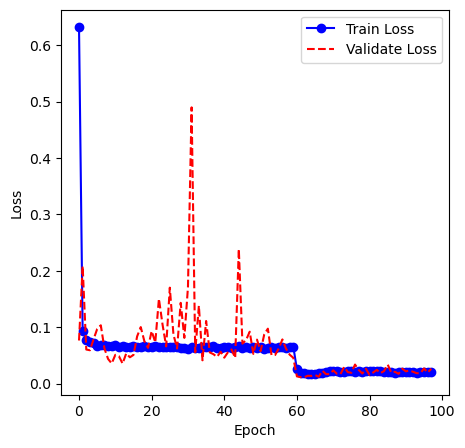

 49%|████████████████████████████████████▎                                     | 98/200 [12:17:32<12:41:11, 447.76s/it]

Epoch:98
Time:12:24:32.202157
Loss:0.020244970186433113
Total:10000  Correct:9938  CleanAccuracy:0.9938


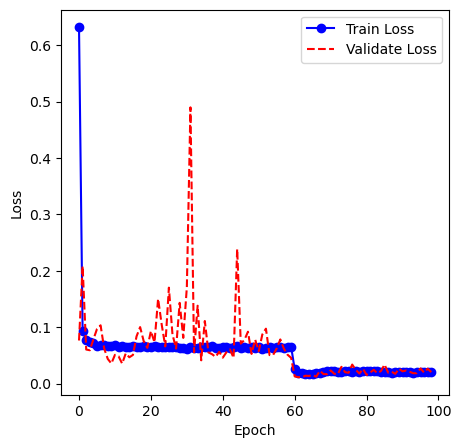

 50%|████████████████████████████████████▋                                     | 99/200 [12:24:54<12:30:42, 445.96s/it]

Epoch:99
Time:12:31:57.315979
Loss:0.01743059239223616
Total:10000  Correct:9947  CleanAccuracy:0.9947


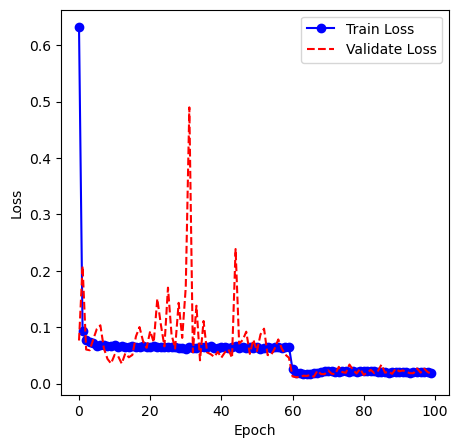

 50%|████████████████████████████████████▌                                    | 100/200 [12:32:27<12:26:44, 448.05s/it]

Epoch:100
Time:12:39:27.836377
Loss:0.016255134319869455
Total:10000  Correct:9951  CleanAccuracy:0.9951


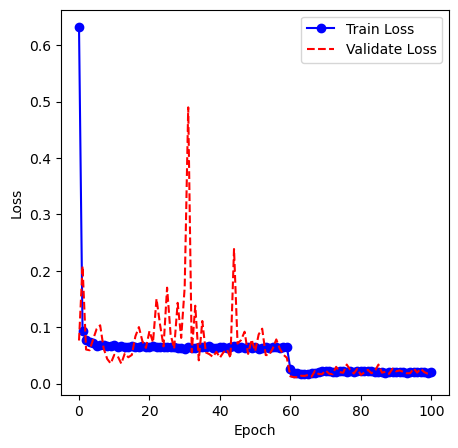

 50%|████████████████████████████████████▊                                    | 101/200 [12:39:59<12:21:15, 449.25s/it]

Epoch:101
Time:12:47:01.633243
Loss:0.022754122387802306
Total:10000  Correct:9939  CleanAccuracy:0.9939


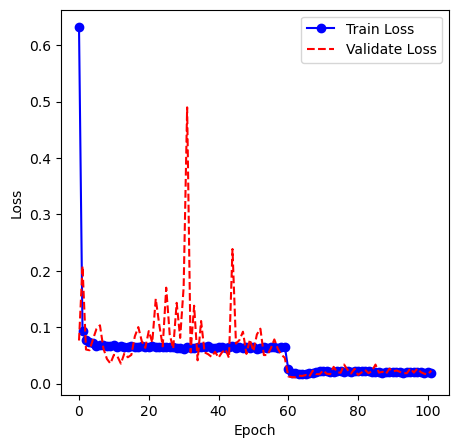

 51%|█████████████████████████████████████▏                                   | 102/200 [12:47:32<12:15:40, 450.41s/it]

Epoch:102
Time:12:54:40.579826
Loss:0.029189949390012026
Total:10000  Correct:9919  CleanAccuracy:0.9919


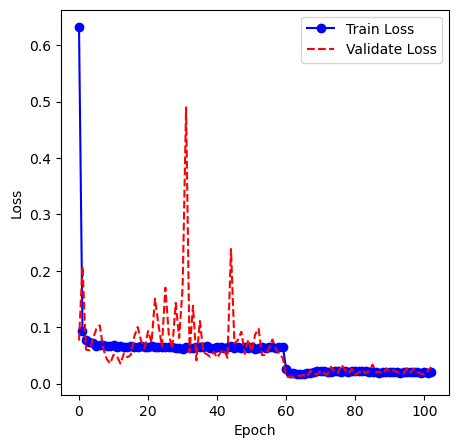

 52%|█████████████████████████████████████▌                                   | 103/200 [12:55:09<12:11:23, 452.41s/it]

Epoch:103
Time:13:02:12.854956
Loss:0.02540321720555014
Total:10000  Correct:9927  CleanAccuracy:0.9927


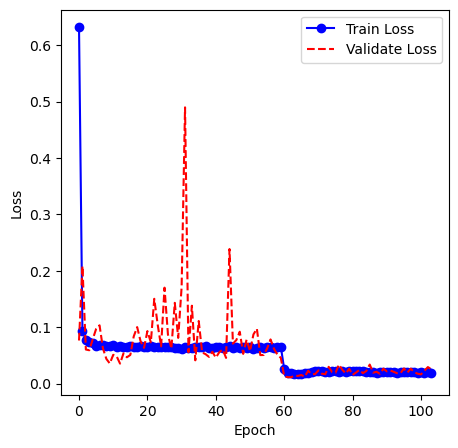

 52%|█████████████████████████████████████▉                                   | 104/200 [13:02:39<12:02:50, 451.78s/it]

Epoch:104
Time:13:09:47.408597
Loss:0.02092354897649203
Total:10000  Correct:9930  CleanAccuracy:0.9930


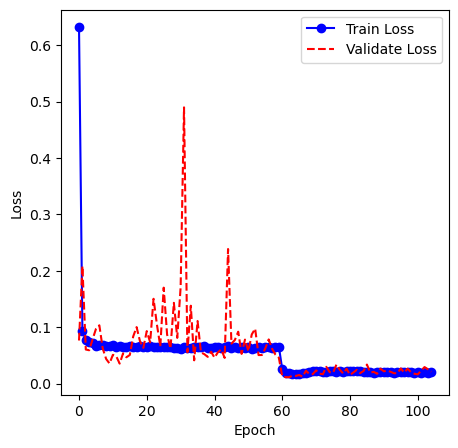

 52%|██████████████████████████████████████▎                                  | 105/200 [13:10:14<11:56:32, 452.55s/it]

Epoch:105
Time:13:17:17.538811
Loss:0.019881087781273024
Total:10000  Correct:9942  CleanAccuracy:0.9942


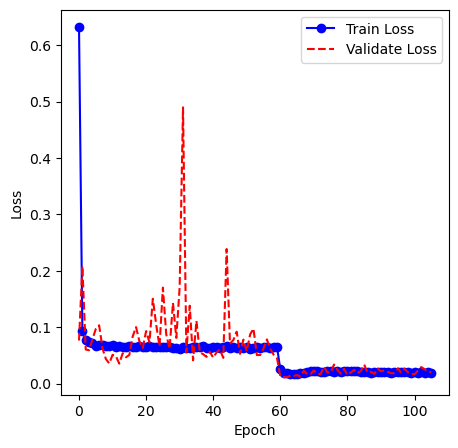

 53%|██████████████████████████████████████▋                                  | 106/200 [13:17:44<11:47:50, 451.81s/it]

Epoch:106
Time:13:24:52.891121
Loss:0.02114223517844239
Total:10000  Correct:9944  CleanAccuracy:0.9944


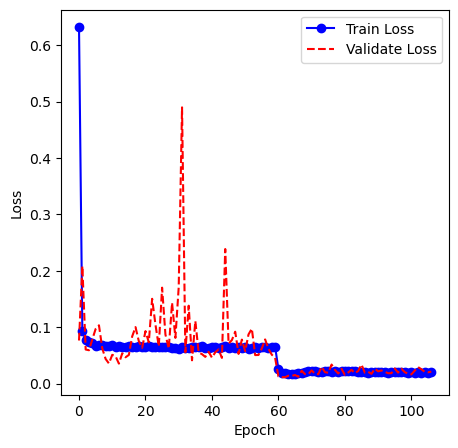

 54%|███████████████████████████████████████                                  | 107/200 [13:25:21<11:42:56, 453.51s/it]

Epoch:107
Time:13:32:27.900144
Loss:0.021351380208099912
Total:10000  Correct:9937  CleanAccuracy:0.9937


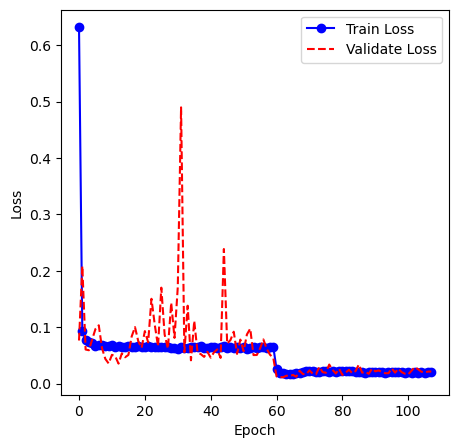

 54%|███████████████████████████████████████▍                                 | 108/200 [13:32:56<11:35:48, 453.79s/it]

Epoch:108
Time:13:40:04.453742
Loss:0.026666142223585106
Total:10000  Correct:9920  CleanAccuracy:0.9920


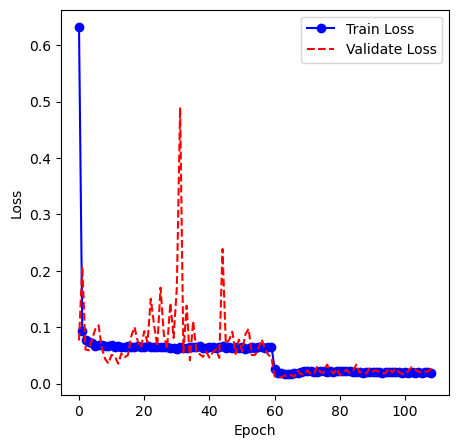

 55%|███████████████████████████████████████▊                                 | 109/200 [13:40:31<11:28:53, 454.21s/it]

Epoch:109
Time:13:47:40.712829
Loss:0.020271031094023947
Total:10000  Correct:9931  CleanAccuracy:0.9931


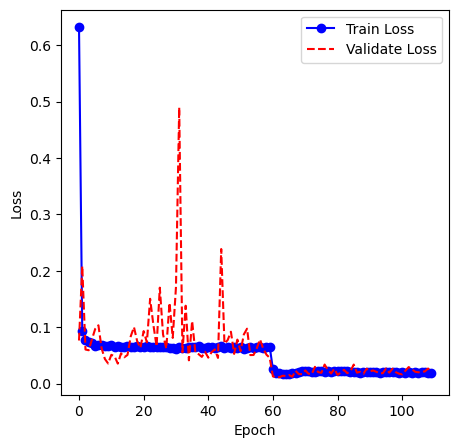

 55%|████████████████████████████████████████▏                                | 110/200 [13:48:05<11:21:17, 454.19s/it]

Epoch:110
Time:13:55:15.595964
Loss:0.02201812055485231
Total:10000  Correct:9929  CleanAccuracy:0.9929


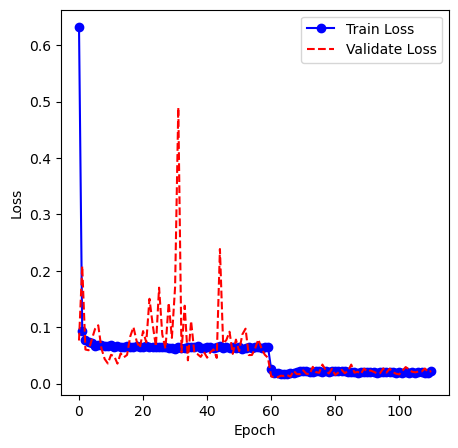

 56%|████████████████████████████████████████▌                                | 111/200 [13:55:45<11:16:32, 456.09s/it]

Epoch:111
Time:14:02:54.771233
Loss:0.019028575407270827
Total:10000  Correct:9942  CleanAccuracy:0.9942


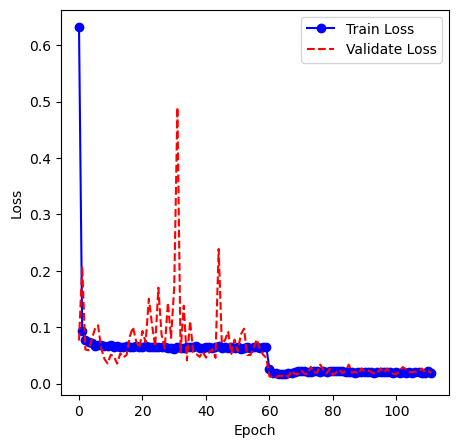

 56%|████████████████████████████████████████▉                                | 112/200 [14:03:21<11:08:43, 455.95s/it]

Epoch:112
Time:14:10:24.219860
Loss:0.019176848554097046
Total:10000  Correct:9943  CleanAccuracy:0.9943


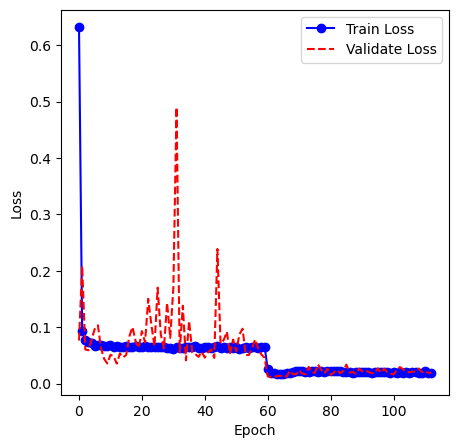

 56%|█████████████████████████████████████████▏                               | 113/200 [14:10:49<10:57:48, 453.67s/it]

Epoch:113
Time:14:17:56.518074
Loss:0.02259847873408264
Total:10000  Correct:9937  CleanAccuracy:0.9937


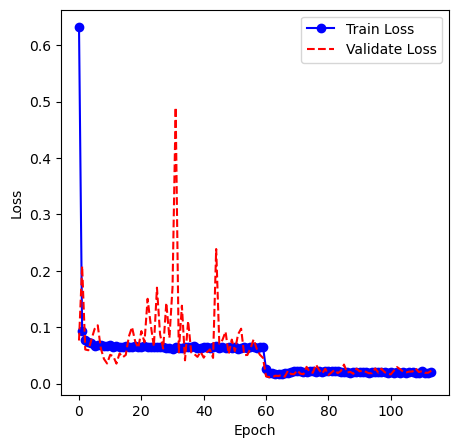

 57%|█████████████████████████████████████████▌                               | 114/200 [14:18:21<10:49:21, 453.04s/it]

Epoch:114
Time:14:25:25.011357
Loss:0.021193581327958518
Total:10000  Correct:9940  CleanAccuracy:0.9940


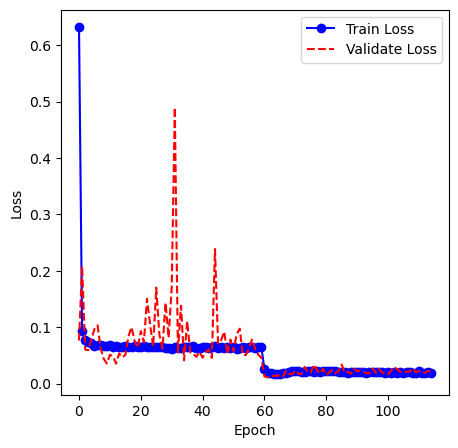

 57%|█████████████████████████████████████████▉                               | 115/200 [14:25:56<10:42:42, 453.68s/it]

Epoch:115
Time:14:32:56.221585
Loss:0.018251905418611086
Total:10000  Correct:9948  CleanAccuracy:0.9948


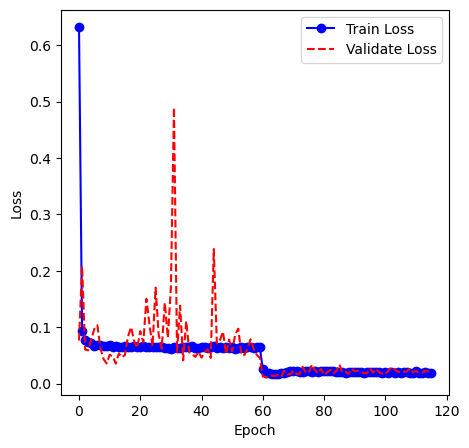

 58%|██████████████████████████████████████████▎                              | 116/200 [14:33:27<10:33:52, 452.76s/it]

Epoch:116
Time:14:40:26.529600
Loss:0.01783290766195369
Total:10000  Correct:9941  CleanAccuracy:0.9941


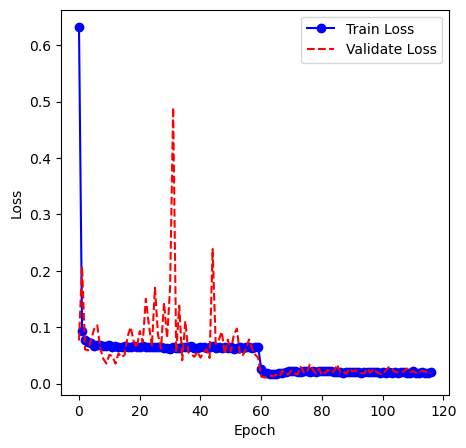

 58%|██████████████████████████████████████████▋                              | 117/200 [14:40:52<10:23:17, 450.57s/it]

Epoch:117
Time:14:47:55.544116
Loss:0.019206914428685502
Total:10000  Correct:9940  CleanAccuracy:0.9940


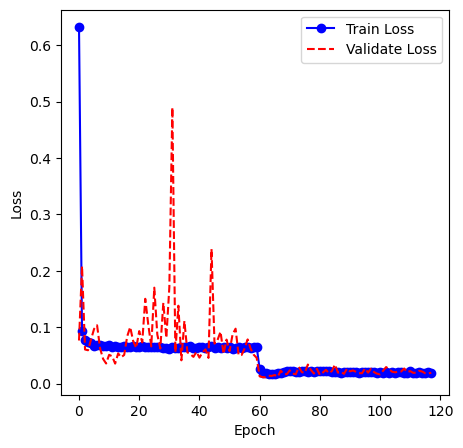

 59%|███████████████████████████████████████████                              | 118/200 [14:48:16<10:12:51, 448.44s/it]

Epoch:118
Time:14:55:21.394705
Loss:0.02417420565822763
Total:10000  Correct:9934  CleanAccuracy:0.9934


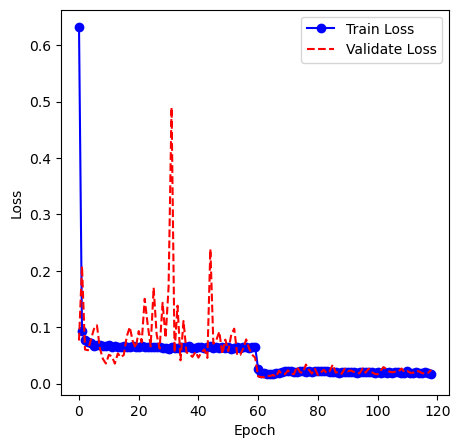

 60%|███████████████████████████████████████████▍                             | 119/200 [14:55:52<10:08:23, 450.66s/it]

Epoch:119
Time:15:02:51.288957
Loss:0.017427084573894924
Total:10000  Correct:9945  CleanAccuracy:0.9945


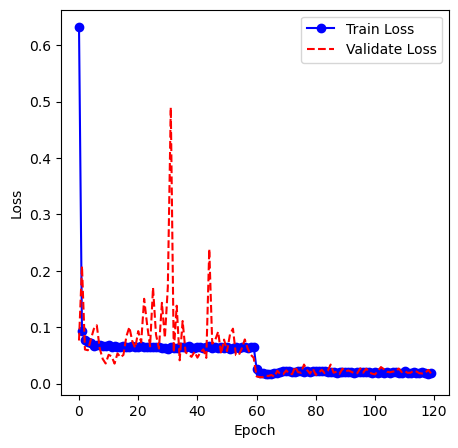

 60%|████████████████████████████████████████████▍                             | 120/200 [15:03:16<9:58:24, 448.81s/it]

Epoch:120
Time:15:10:23.392390
Loss:0.010499853980230962
Total:10000  Correct:9974  CleanAccuracy:0.9974


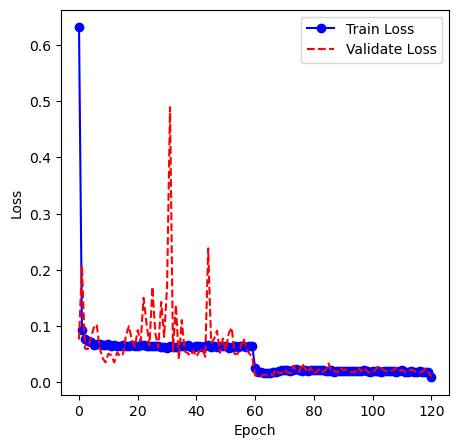

 60%|████████████████████████████████████████████▊                             | 121/200 [15:10:48<9:51:59, 449.61s/it]

Epoch:121
Time:15:17:53.921563
Loss:0.009662200872598144
Total:10000  Correct:9970  CleanAccuracy:0.9970


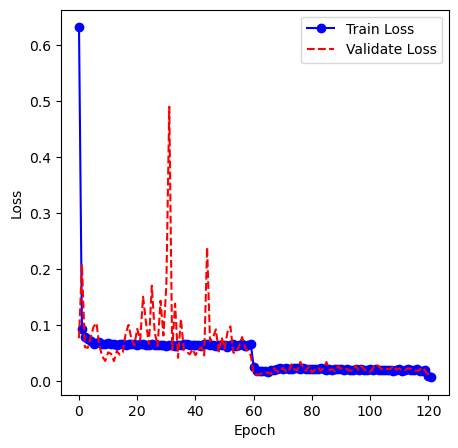

 61%|█████████████████████████████████████████████▏                            | 122/200 [15:18:19<9:45:04, 450.06s/it]

Epoch:122
Time:15:25:25.882986
Loss:0.009789431078795392
Total:10000  Correct:9972  CleanAccuracy:0.9972


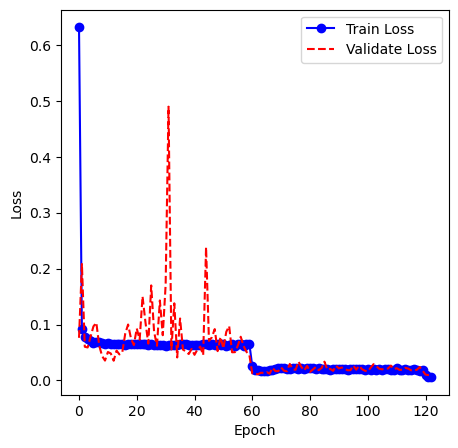

 62%|█████████████████████████████████████████████▌                            | 123/200 [15:25:52<9:38:50, 451.05s/it]

Epoch:123
Time:15:32:59.459437
Loss:0.00980474833294358
Total:10000  Correct:9976  CleanAccuracy:0.9976


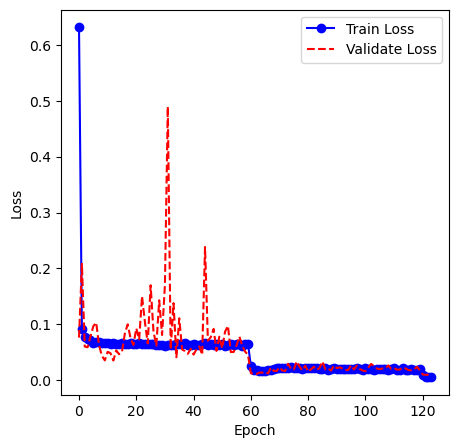

 62%|█████████████████████████████████████████████▉                            | 124/200 [15:33:28<9:33:10, 452.51s/it]

Epoch:124
Time:15:40:32.058050
Loss:0.009571258005968402
Total:10000  Correct:9976  CleanAccuracy:0.9976


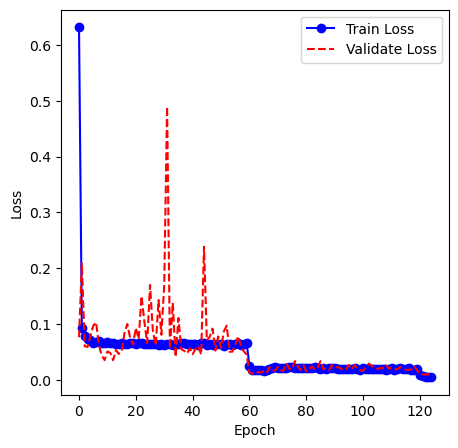

 62%|██████████████████████████████████████████████▎                           | 125/200 [15:40:57<9:24:14, 451.39s/it]

Epoch:125
Time:15:48:03.807398
Loss:0.009178213470730003
Total:10000  Correct:9974  CleanAccuracy:0.9974


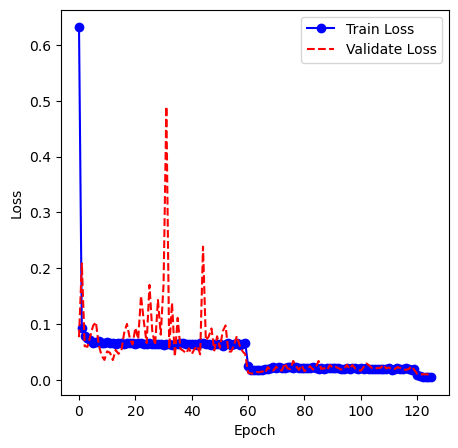

 63%|██████████████████████████████████████████████▌                           | 126/200 [15:48:31<9:17:40, 452.17s/it]

Epoch:126
Time:15:55:40.058588
Loss:0.010065030379848667
Total:10000  Correct:9970  CleanAccuracy:0.9970


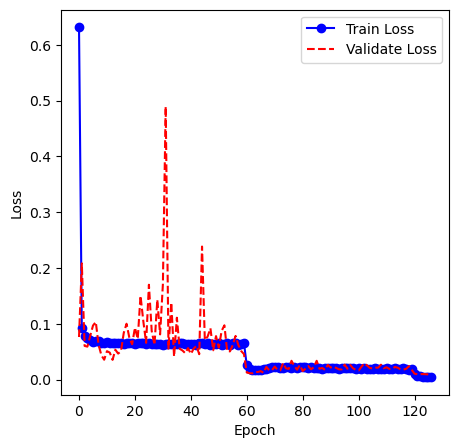

 64%|██████████████████████████████████████████████▉                           | 127/200 [15:56:07<9:11:35, 453.36s/it]

Epoch:127
Time:16:03:17.005821
Loss:0.010384517539956103
Total:10000  Correct:9971  CleanAccuracy:0.9971


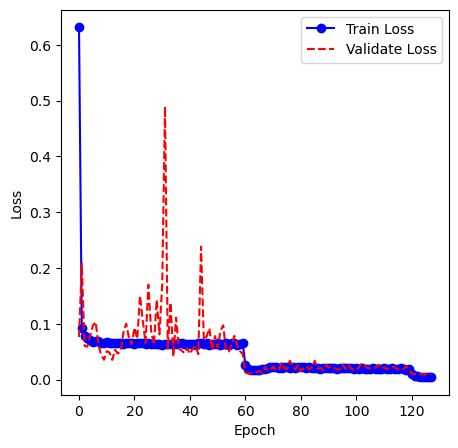

 64%|███████████████████████████████████████████████▎                          | 128/200 [16:03:43<9:04:59, 454.17s/it]

Epoch:128
Time:16:10:53.345424
Loss:0.010595000741282513
Total:10000  Correct:9971  CleanAccuracy:0.9971


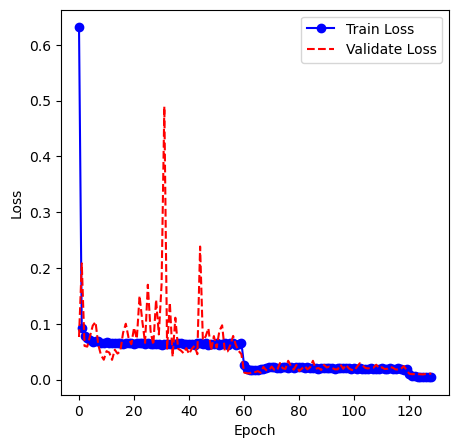

 64%|███████████████████████████████████████████████▋                          | 129/200 [16:11:20<8:58:31, 455.09s/it]

Epoch:129
Time:16:18:26.775656
Loss:0.011432323532388025
Total:10000  Correct:9971  CleanAccuracy:0.9971


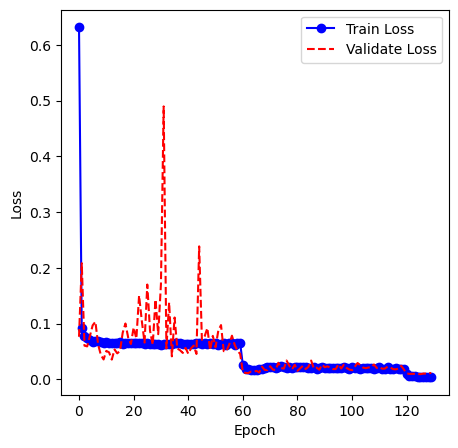

 65%|████████████████████████████████████████████████                          | 130/200 [16:18:56<8:51:04, 455.20s/it]

Epoch:130
Time:16:26:03.315744
Loss:0.010727427663566462
Total:10000  Correct:9968  CleanAccuracy:0.9968


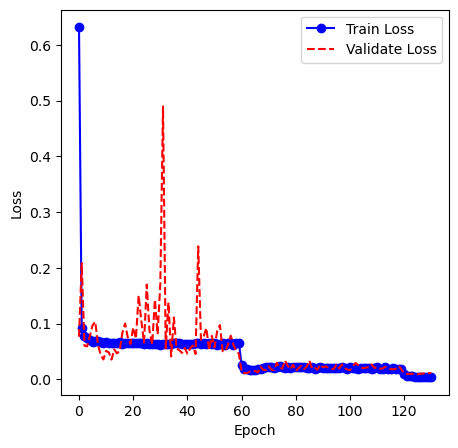

 66%|████████████████████████████████████████████████▍                         | 131/200 [16:26:29<8:42:47, 454.60s/it]

Epoch:131
Time:16:33:33.200330
Loss:0.010348514521240849
Total:10000  Correct:9972  CleanAccuracy:0.9972


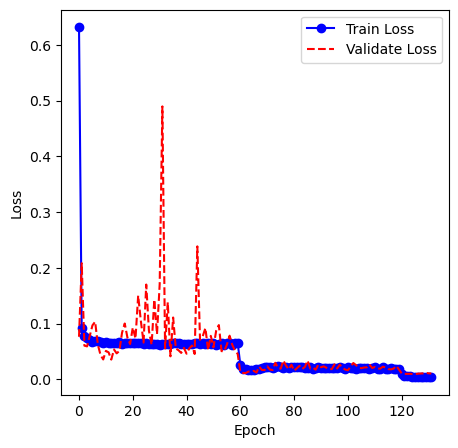

 66%|████████████████████████████████████████████████▊                         | 132/200 [16:34:03<8:35:08, 454.54s/it]

Epoch:132
Time:16:41:03.808152
Loss:0.011174958901566872
Total:10000  Correct:9975  CleanAccuracy:0.9975


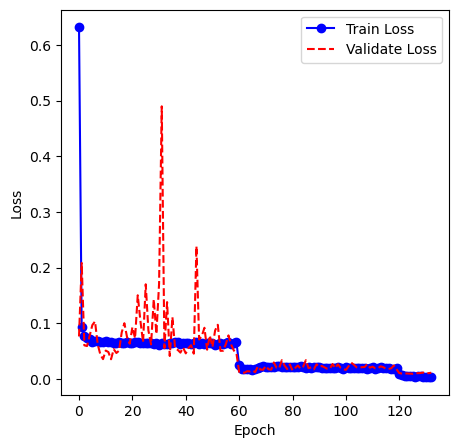

 66%|█████████████████████████████████████████████████▏                        | 133/200 [16:41:29<8:24:35, 451.87s/it]

Epoch:133
Time:16:48:26.831694
Loss:0.011512707830919995
Total:10000  Correct:9972  CleanAccuracy:0.9972


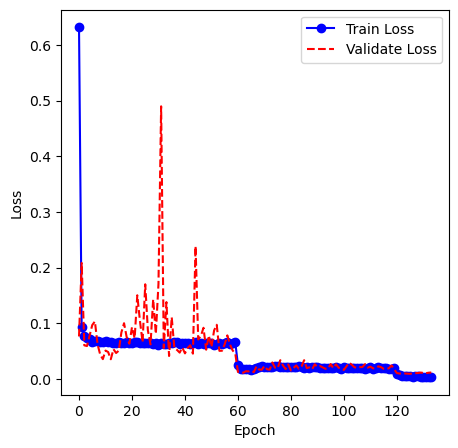

 67%|█████████████████████████████████████████████████▌                        | 134/200 [16:48:55<8:15:16, 450.25s/it]

Epoch:134
Time:16:55:57.576907
Loss:0.010628956611254833
Total:10000  Correct:9970  CleanAccuracy:0.9970


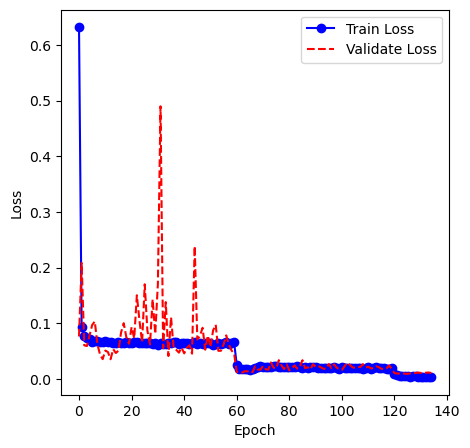

 68%|█████████████████████████████████████████████████▉                        | 135/200 [16:56:21<8:06:27, 449.03s/it]

Epoch:135
Time:17:03:21.634157
Loss:0.009685027308649749
Total:10000  Correct:9970  CleanAccuracy:0.9970


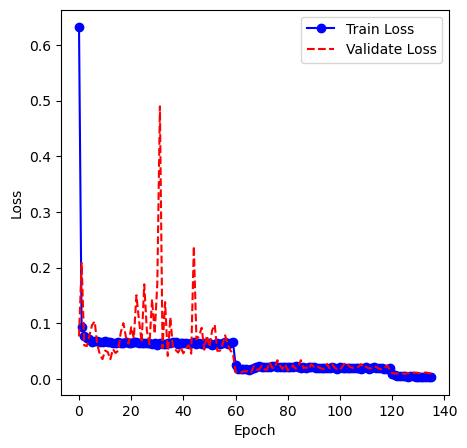

 68%|██████████████████████████████████████████████████▎                       | 136/200 [17:03:48<7:58:07, 448.24s/it]

Epoch:136
Time:17:10:56.160728
Loss:0.011042761715343252
Total:10000  Correct:9969  CleanAccuracy:0.9969


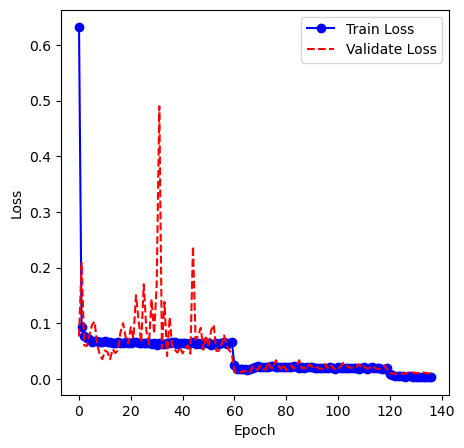

 68%|██████████████████████████████████████████████████▋                       | 137/200 [17:11:21<7:52:11, 449.70s/it]

Epoch:137
Time:17:18:25.380851
Loss:0.010747680531575913
Total:10000  Correct:9972  CleanAccuracy:0.9972


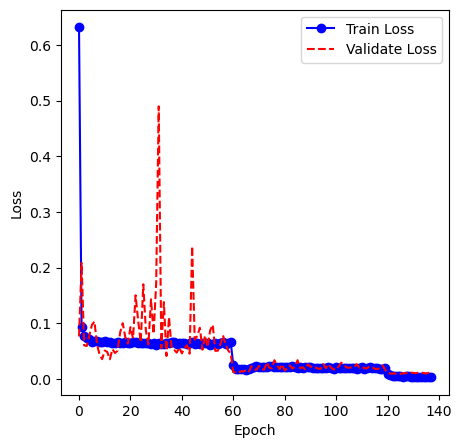

 69%|███████████████████████████████████████████████████                       | 138/200 [17:18:51<7:44:53, 449.90s/it]

Epoch:138
Time:17:26:04.227184
Loss:0.011688057563644045
Total:10000  Correct:9973  CleanAccuracy:0.9973


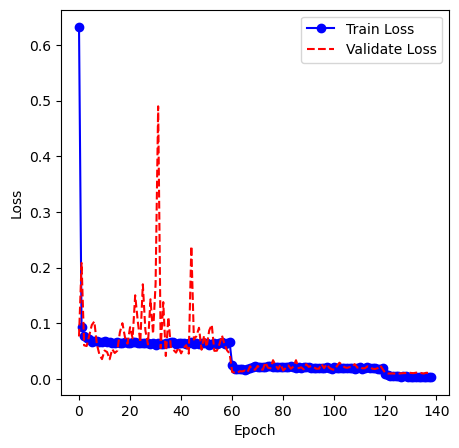

 70%|███████████████████████████████████████████████████▍                      | 139/200 [17:26:31<7:40:21, 452.81s/it]

Epoch:139
Time:17:33:42.214799
Loss:0.012028426925923985
Total:10000  Correct:9968  CleanAccuracy:0.9968


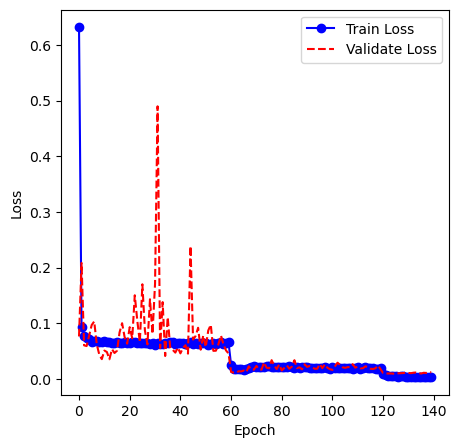

 70%|███████████████████████████████████████████████████▊                      | 140/200 [17:34:10<7:34:39, 454.66s/it]

Epoch:140
Time:17:41:22.186465
Loss:0.01271606385934735
Total:10000  Correct:9974  CleanAccuracy:0.9974


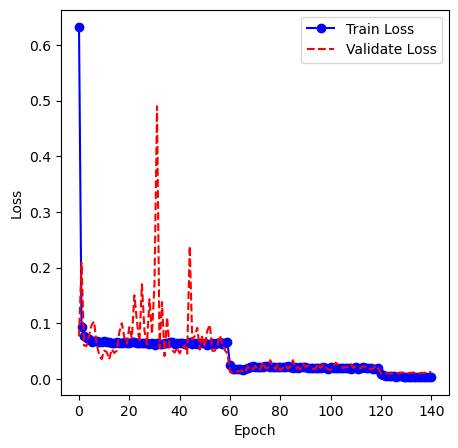

 70%|████████████████████████████████████████████████████▏                     | 141/200 [17:41:49<7:28:32, 456.14s/it]

Epoch:141
Time:17:49:02.679280
Loss:0.01197908845352241
Total:10000  Correct:9972  CleanAccuracy:0.9972


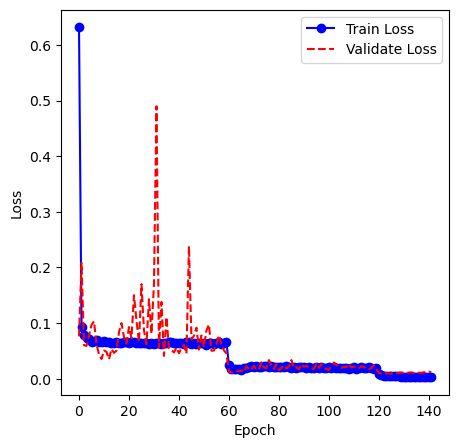

 71%|████████████████████████████████████████████████████▌                     | 142/200 [17:49:30<7:22:04, 457.33s/it]

Epoch:142
Time:17:56:38.072802
Loss:0.01186242878737193
Total:10000  Correct:9970  CleanAccuracy:0.9970


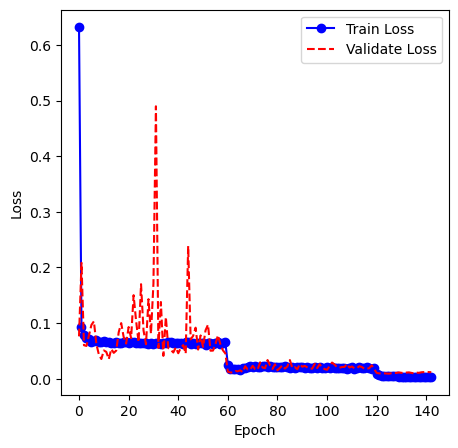

 72%|████████████████████████████████████████████████████▉                     | 143/200 [17:57:03<7:13:15, 456.07s/it]

Epoch:143
Time:18:04:21.036664
Loss:0.012158771287913943
Total:10000  Correct:9970  CleanAccuracy:0.9970


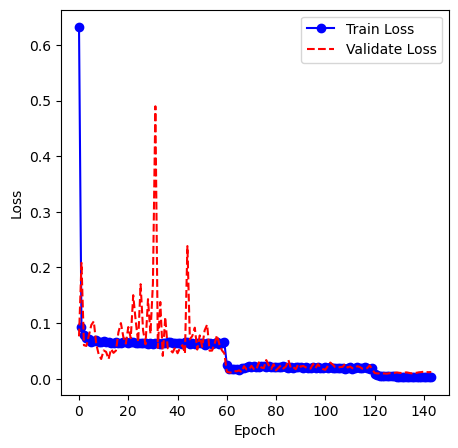

 72%|█████████████████████████████████████████████████████▎                    | 144/200 [18:04:50<7:08:52, 459.51s/it]

Epoch:144
Time:18:12:13.272402
Loss:0.011057890220969237
Total:10000  Correct:9976  CleanAccuracy:0.9976


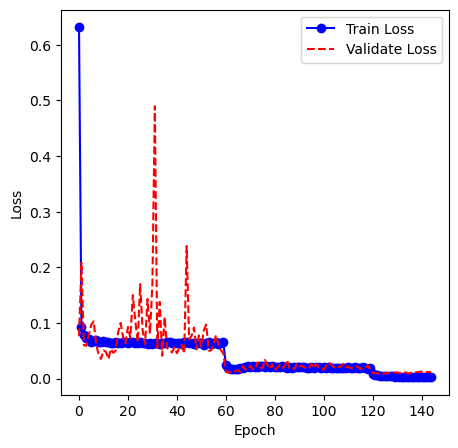

 72%|█████████████████████████████████████████████████████▋                    | 145/200 [18:12:39<7:03:41, 462.21s/it]

Epoch:145
Time:18:19:53.198568
Loss:0.012812014759652846
Total:10000  Correct:9966  CleanAccuracy:0.9966


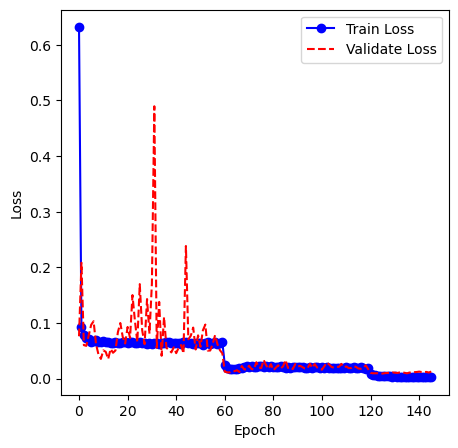

 73%|██████████████████████████████████████████████████████                    | 146/200 [18:20:19<6:55:21, 461.50s/it]

Epoch:146
Time:18:27:31.834864
Loss:0.011916120207091919
Total:10000  Correct:9975  CleanAccuracy:0.9975


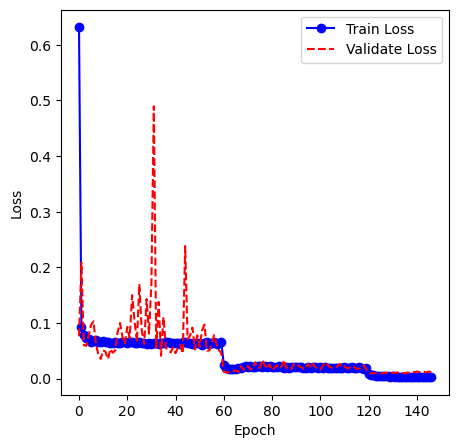

 74%|██████████████████████████████████████████████████████▍                   | 147/200 [18:27:56<6:46:28, 460.16s/it]

Epoch:147
Time:18:35:03.083798
Loss:0.013357240156126998
Total:10000  Correct:9968  CleanAccuracy:0.9968


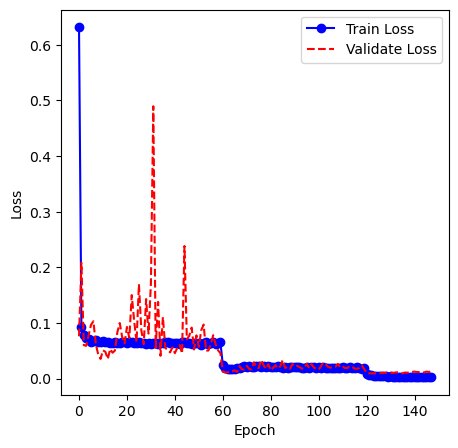

 74%|██████████████████████████████████████████████████████▊                   | 148/200 [18:35:31<6:37:36, 458.78s/it]

Epoch:148
Time:18:42:46.547999
Loss:0.011797733248037378
Total:10000  Correct:9974  CleanAccuracy:0.9974


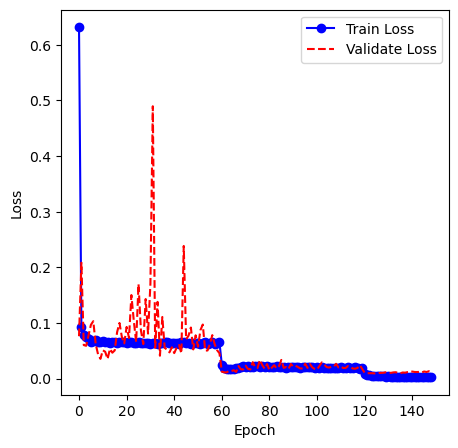

 74%|███████████████████████████████████████████████████████▏                  | 149/200 [18:43:11<6:30:11, 459.05s/it]

Epoch:149
Time:18:50:18.112592
Loss:0.011580893940949877
Total:10000  Correct:9973  CleanAccuracy:0.9973


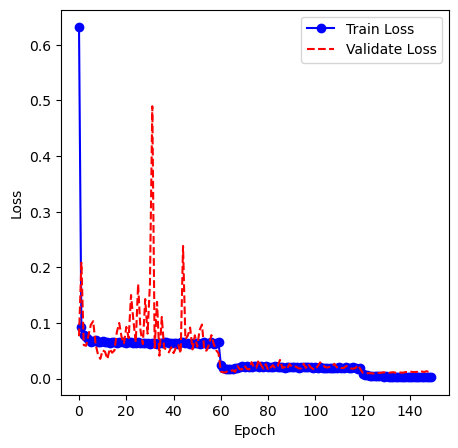

 75%|███████████████████████████████████████████████████████▌                  | 150/200 [18:50:47<6:21:52, 458.24s/it]

Epoch:150
Time:18:57:53.455369
Loss:0.011066737088609856
Total:10000  Correct:9974  CleanAccuracy:0.9974


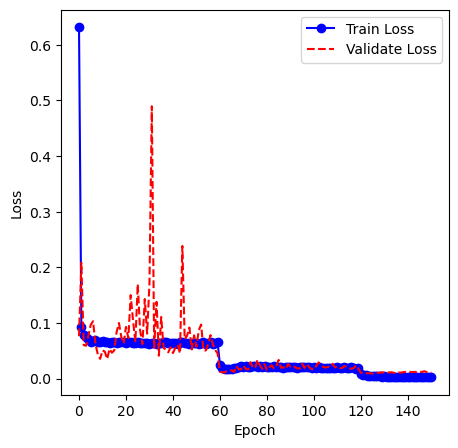

 76%|███████████████████████████████████████████████████████▊                  | 151/200 [18:58:24<6:13:47, 457.70s/it]

Epoch:151
Time:19:05:33.387205
Loss:0.01376976729632867
Total:10000  Correct:9969  CleanAccuracy:0.9969


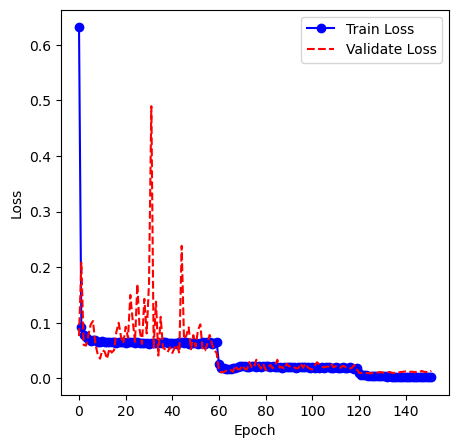

 76%|████████████████████████████████████████████████████████▏                 | 152/200 [19:05:59<6:05:31, 456.90s/it]

Epoch:152
Time:19:13:10.278676
Loss:0.013211029298497906
Total:10000  Correct:9969  CleanAccuracy:0.9969


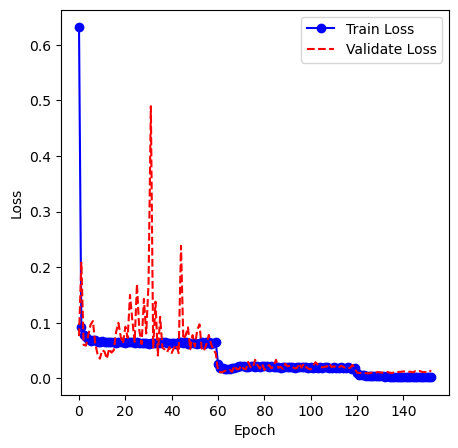

 76%|████████████████████████████████████████████████████████▌                 | 153/200 [19:13:34<5:57:30, 456.40s/it]

Epoch:153
Time:19:20:47.640474
Loss:0.01503574902226348
Total:10000  Correct:9963  CleanAccuracy:0.9963


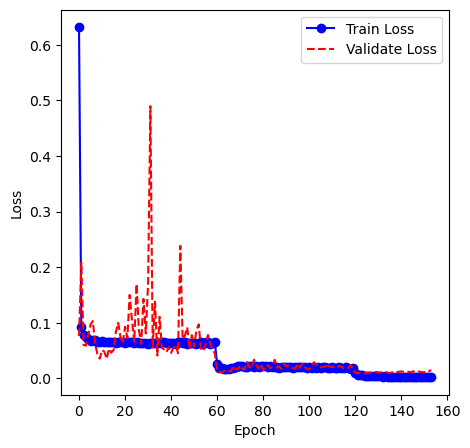

 77%|████████████████████████████████████████████████████████▉                 | 154/200 [19:21:16<5:51:11, 458.08s/it]

Epoch:154
Time:19:28:31.533061
Loss:0.01365148249004533
Total:10000  Correct:9966  CleanAccuracy:0.9966


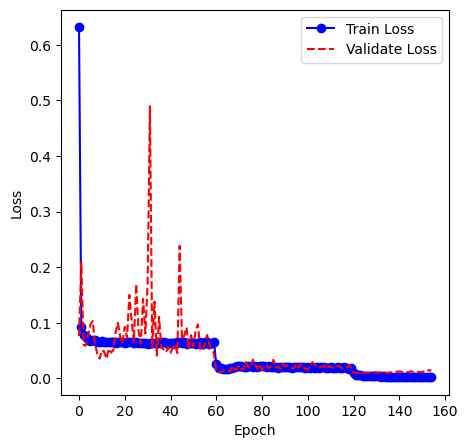

 78%|█████████████████████████████████████████████████████████▎                | 155/200 [19:28:54<5:43:34, 458.10s/it]

Epoch:155
Time:19:36:13.891390
Loss:0.01263690443448023
Total:10000  Correct:9971  CleanAccuracy:0.9971


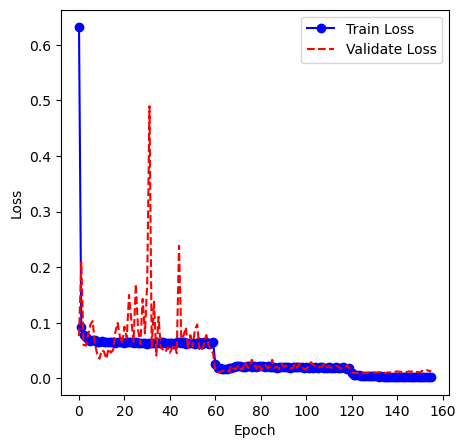

 78%|█████████████████████████████████████████████████████████▋                | 156/200 [19:36:44<5:38:35, 461.71s/it]

Epoch:156
Time:19:43:54.930366
Loss:0.014033101432318517
Total:10000  Correct:9961  CleanAccuracy:0.9961


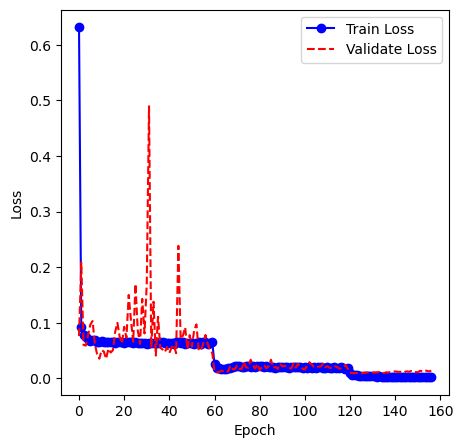

 78%|██████████████████████████████████████████████████████████                | 157/200 [19:44:30<5:31:43, 462.88s/it]

Epoch:157
Time:19:51:45.189447
Loss:0.0162936332953585
Total:10000  Correct:9961  CleanAccuracy:0.9961


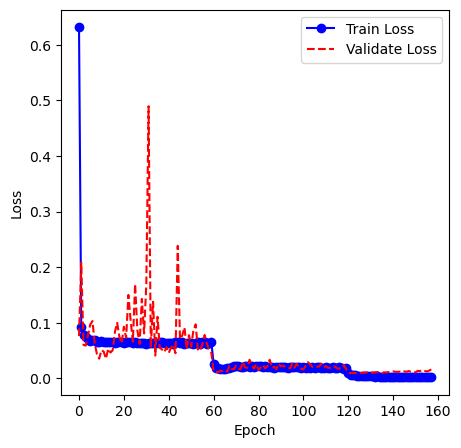

 79%|██████████████████████████████████████████████████████████▍               | 158/200 [19:52:11<5:23:43, 462.46s/it]

Epoch:158
Time:19:59:23.533772
Loss:0.013917076478681761
Total:10000  Correct:9967  CleanAccuracy:0.9967


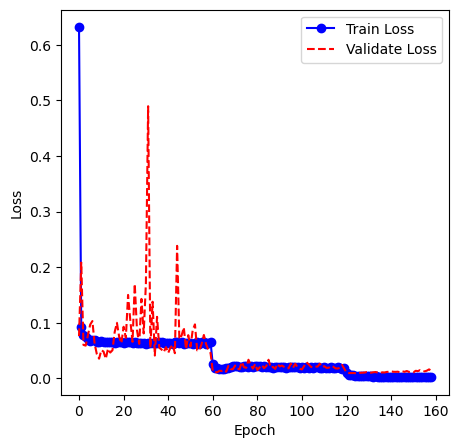

 80%|██████████████████████████████████████████████████████████▊               | 159/200 [19:59:55<5:16:13, 462.77s/it]

Epoch:159
Time:20:07:14.004785
Loss:0.012649166226753751
Total:10000  Correct:9967  CleanAccuracy:0.9967


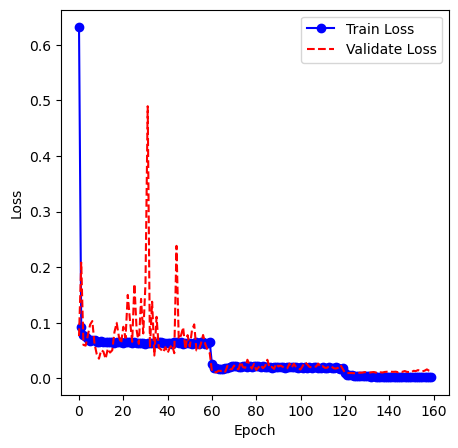

 80%|███████████████████████████████████████████████████████████▏              | 160/200 [20:07:39<5:08:52, 463.31s/it]

Epoch:160
Time:20:14:58.649785
Loss:0.014292042594482622
Total:10000  Correct:9962  CleanAccuracy:0.9962


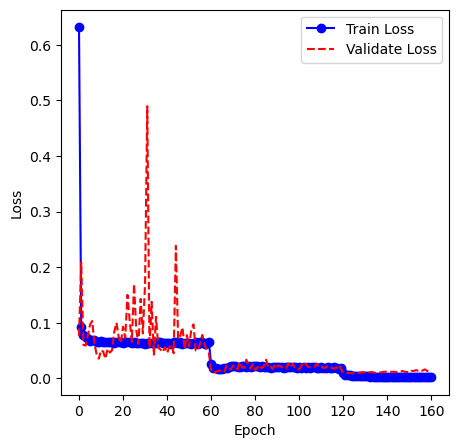

 80%|███████████████████████████████████████████████████████████▌              | 161/200 [20:15:25<5:01:32, 463.92s/it]

Epoch:161
Time:20:22:39.165900
Loss:0.011983501075502164
Total:10000  Correct:9971  CleanAccuracy:0.9971


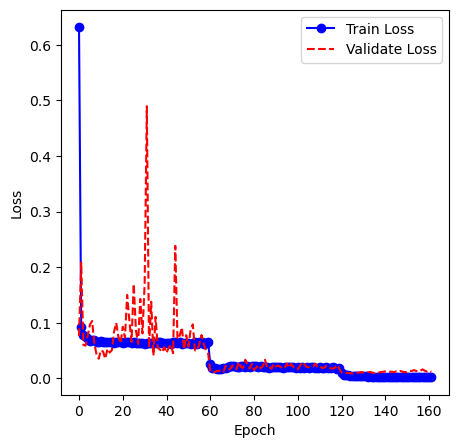

 81%|███████████████████████████████████████████████████████████▉              | 162/200 [20:23:13<4:54:39, 465.25s/it]

Epoch:162
Time:20:30:32.226137
Loss:0.011865019979875553
Total:10000  Correct:9969  CleanAccuracy:0.9969


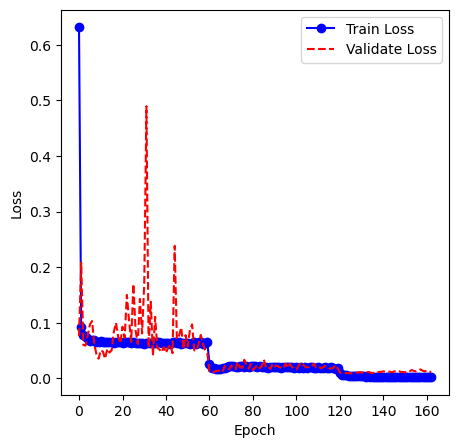

 82%|████████████████████████████████████████████████████████████▎             | 163/200 [20:31:02<4:47:30, 466.22s/it]

Epoch:163
Time:20:38:30.497368
Loss:0.012315830922207257
Total:10000  Correct:9964  CleanAccuracy:0.9964


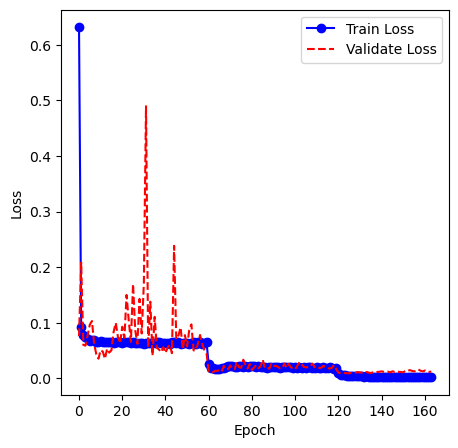

 82%|████████████████████████████████████████████████████████████▋             | 164/200 [20:39:08<4:43:22, 472.28s/it]

Epoch:164
Time:20:46:48.043286
Loss:0.013634228185875515
Total:10000  Correct:9963  CleanAccuracy:0.9963


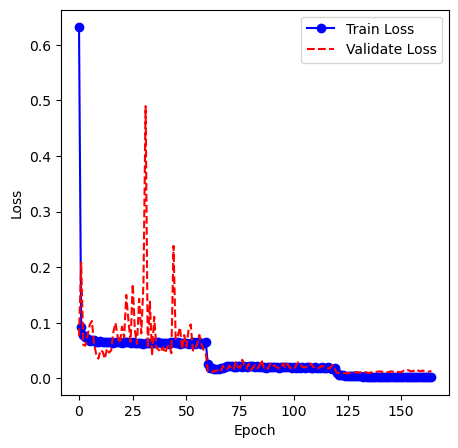

 82%|█████████████████████████████████████████████████████████████             | 165/200 [20:47:22<4:39:16, 478.76s/it]

Epoch:165
Time:20:55:01.255685
Loss:0.01338179185264967
Total:10000  Correct:9973  CleanAccuracy:0.9973


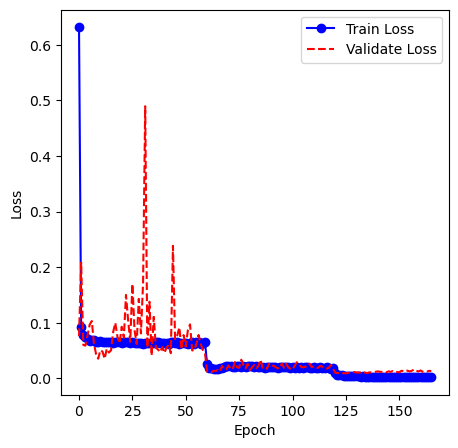

 83%|█████████████████████████████████████████████████████████████▍            | 166/200 [20:55:27<4:32:20, 480.61s/it]

Epoch:166
Time:21:03:07.923692
Loss:0.012327746387173872
Total:10000  Correct:9966  CleanAccuracy:0.9966


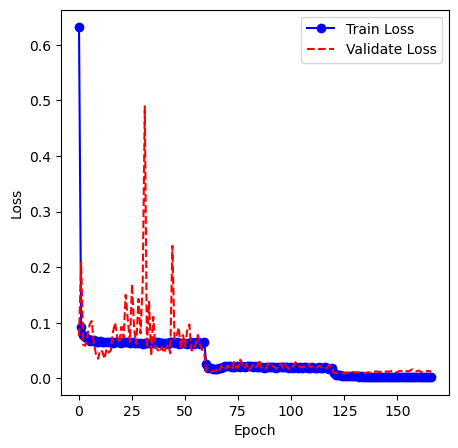

 84%|█████████████████████████████████████████████████████████████▊            | 167/200 [21:03:43<4:26:50, 485.17s/it]

Epoch:167
Time:21:11:13.081600
Loss:0.015563151501967146
Total:10000  Correct:9967  CleanAccuracy:0.9967


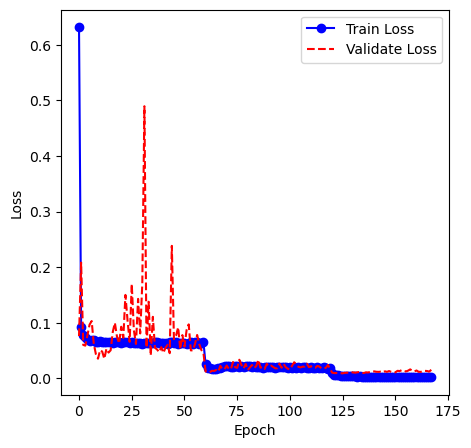

 84%|██████████████████████████████████████████████████████████████▏           | 168/200 [21:11:44<4:18:09, 484.05s/it]

Epoch:168
Time:21:19:11.127561
Loss:0.01615491680136641
Total:10000  Correct:9962  CleanAccuracy:0.9962


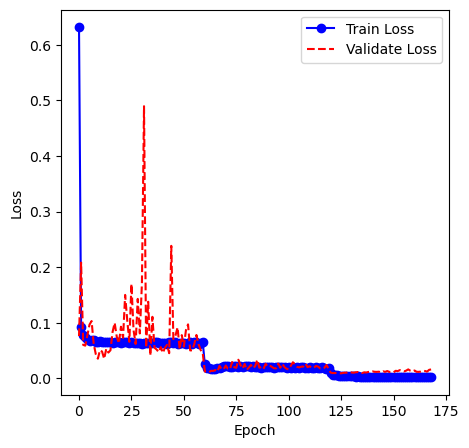

 84%|██████████████████████████████████████████████████████████████▌           | 169/200 [21:19:46<4:09:49, 483.53s/it]

Epoch:169
Time:21:27:15.481180
Loss:0.01342740824063734
Total:10000  Correct:9968  CleanAccuracy:0.9968


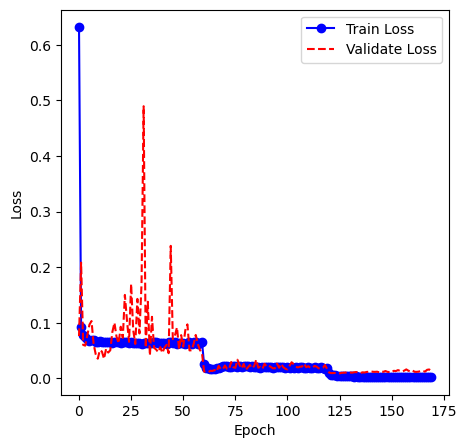

 85%|██████████████████████████████████████████████████████████████▉           | 170/200 [21:27:44<4:00:51, 481.72s/it]

Epoch:170
Time:21:35:23.532002
Loss:0.013589983043363526
Total:10000  Correct:9967  CleanAccuracy:0.9967


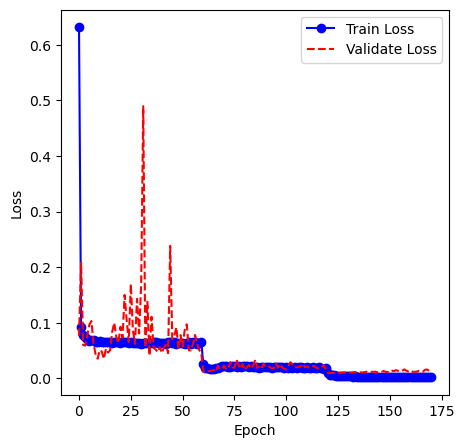

 86%|███████████████████████████████████████████████████████████████▎          | 171/200 [21:35:52<3:53:45, 483.65s/it]

Epoch:171
Time:21:43:39.914690
Loss:0.013681219218815037
Total:10000  Correct:9966  CleanAccuracy:0.9966


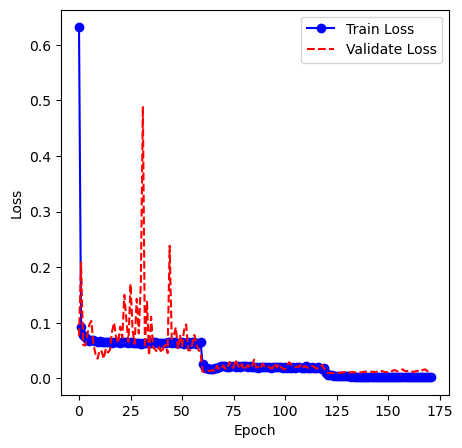

 86%|███████████████████████████████████████████████████████████████▋          | 172/200 [21:44:12<3:47:59, 488.55s/it]

Epoch:172
Time:21:51:51.376947
Loss:0.01371489057504087
Total:10000  Correct:9967  CleanAccuracy:0.9967


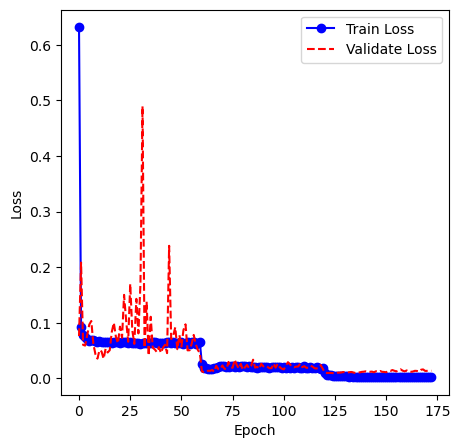

 86%|████████████████████████████████████████████████████████████████          | 173/200 [21:52:27<3:40:39, 490.35s/it]

Epoch:173
Time:21:59:56.809647
Loss:0.014936879153375309
Total:10000  Correct:9963  CleanAccuracy:0.9963


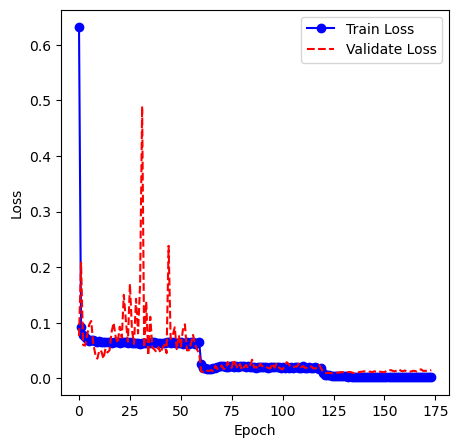

 87%|████████████████████████████████████████████████████████████████▍         | 174/200 [22:00:30<3:31:36, 488.34s/it]

Epoch:174
Time:22:08:12.713176
Loss:0.013741712890953694
Total:10000  Correct:9970  CleanAccuracy:0.9970


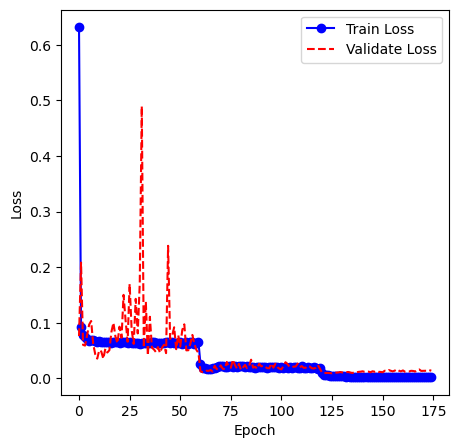

 88%|████████████████████████████████████████████████████████████████▊         | 175/200 [22:08:51<3:25:01, 492.05s/it]

Epoch:175
Time:22:16:32.488938
Loss:0.01338800364516128
Total:10000  Correct:9972  CleanAccuracy:0.9972


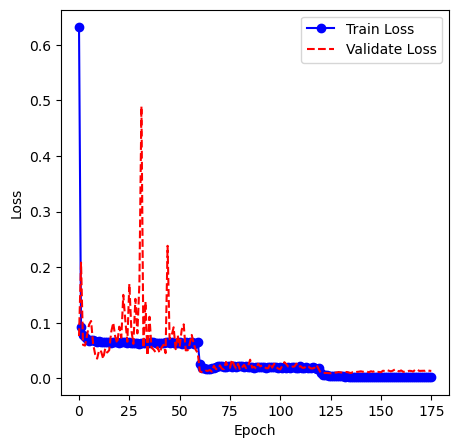

 88%|█████████████████████████████████████████████████████████████████         | 176/200 [22:17:06<3:17:14, 493.09s/it]

Epoch:176
Time:22:24:51.358977
Loss:0.015516470085525255
Total:10000  Correct:9962  CleanAccuracy:0.9962


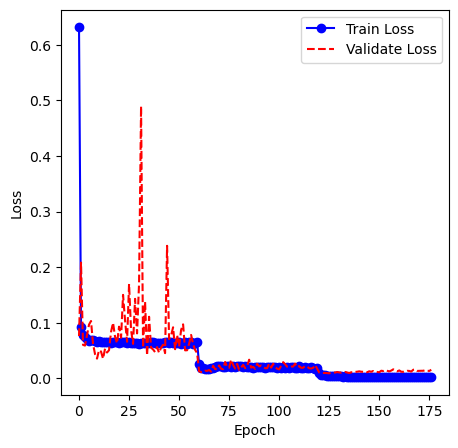

 88%|█████████████████████████████████████████████████████████████████▍        | 177/200 [22:25:24<3:09:33, 494.52s/it]

Epoch:177
Time:22:33:10.543776
Loss:0.015844838162616323
Total:10000  Correct:9960  CleanAccuracy:0.9960


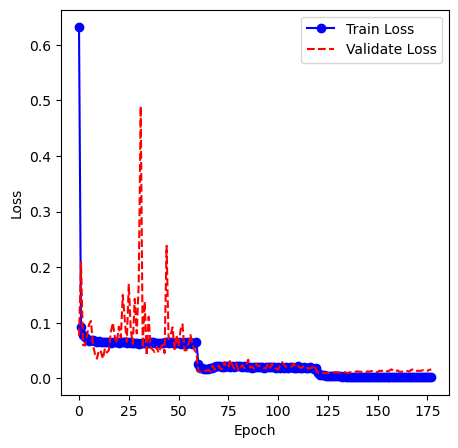

 89%|█████████████████████████████████████████████████████████████████▊        | 178/200 [22:33:48<3:02:21, 497.34s/it]

Epoch:178
Time:22:41:45.387244
Loss:0.018223562809719016
Total:10000  Correct:9952  CleanAccuracy:0.9952


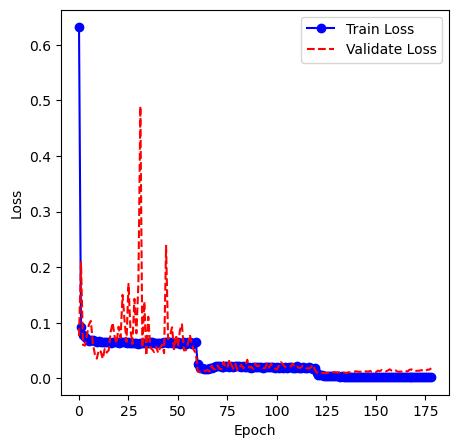

 90%|██████████████████████████████████████████████████████████████████▏       | 179/200 [22:42:22<2:55:49, 502.34s/it]

Epoch:179
Time:22:50:18.293669
Loss:0.013941447143056118
Total:10000  Correct:9963  CleanAccuracy:0.9963


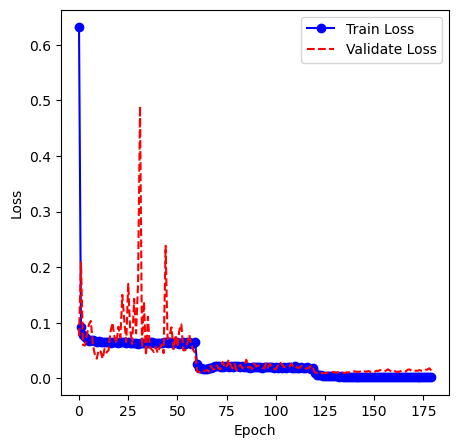

 90%|██████████████████████████████████████████████████████████████████▌       | 180/200 [22:50:56<2:48:33, 505.67s/it]

Epoch:180
Time:22:58:52.452308
Loss:0.013733790599935935
Total:10000  Correct:9964  CleanAccuracy:0.9964


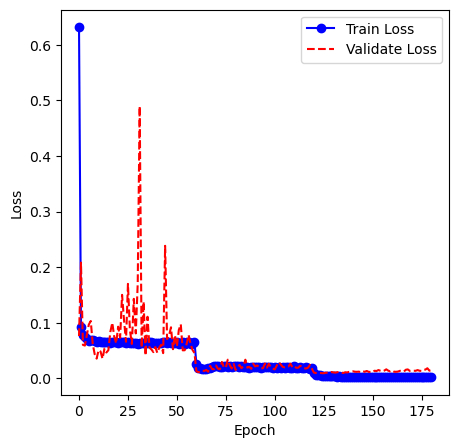

 90%|██████████████████████████████████████████████████████████████████▉       | 181/200 [22:59:26<2:40:35, 507.15s/it]

Epoch:181
Time:23:07:26.620164
Loss:0.013488975586555601
Total:10000  Correct:9966  CleanAccuracy:0.9966


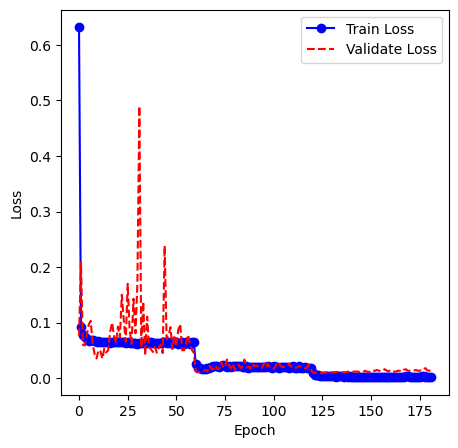

 91%|███████████████████████████████████████████████████████████████████▎      | 182/200 [23:08:03<2:32:58, 509.94s/it]

Epoch:182
Time:23:16:01.511793
Loss:0.013474962959354655
Total:10000  Correct:9965  CleanAccuracy:0.9965


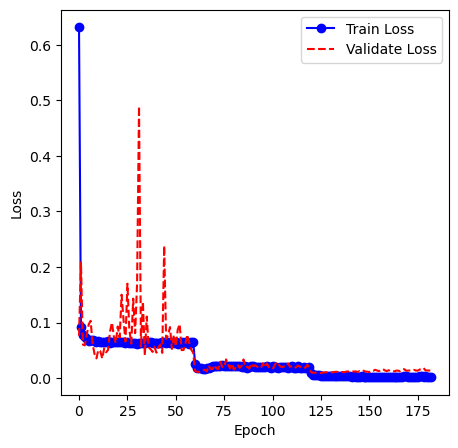

 92%|███████████████████████████████████████████████████████████████████▋      | 183/200 [23:16:38<2:24:57, 511.60s/it]

Epoch:183
Time:23:24:42.290274
Loss:0.01392195433831607
Total:10000  Correct:9964  CleanAccuracy:0.9964


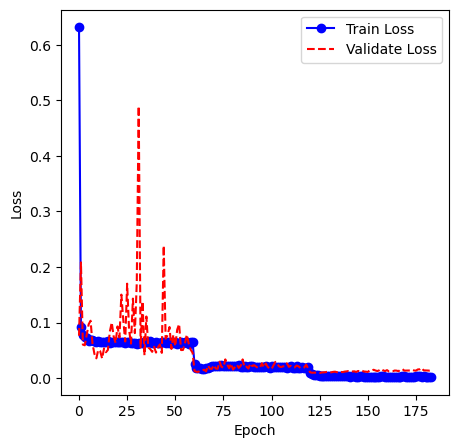

 92%|████████████████████████████████████████████████████████████████████      | 184/200 [23:25:19<2:17:12, 514.51s/it]

Epoch:184
Time:23:33:12.326999
Loss:0.014158655177264775
Total:10000  Correct:9966  CleanAccuracy:0.9966


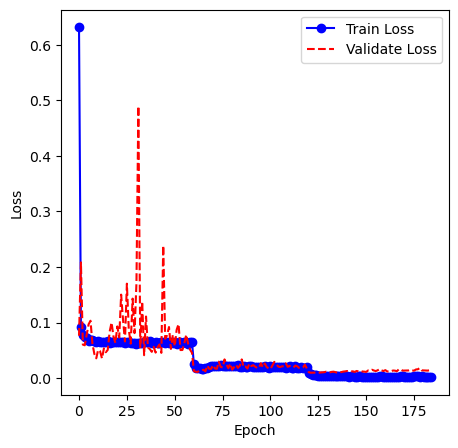

 92%|████████████████████████████████████████████████████████████████████▍     | 185/200 [23:33:50<2:08:18, 513.26s/it]

Epoch:185
Time:23:41:38.852490
Loss:0.01365094111593345
Total:10000  Correct:9964  CleanAccuracy:0.9964


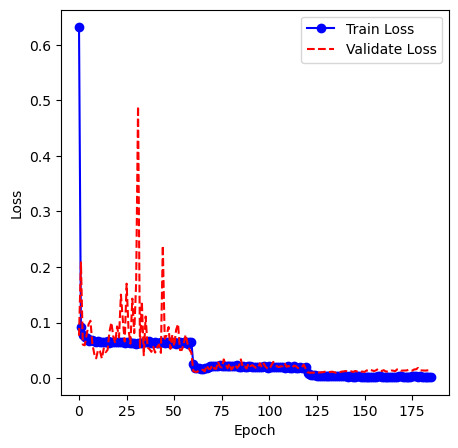

 93%|████████████████████████████████████████████████████████████████████▊     | 186/200 [23:42:09<1:58:45, 508.99s/it]

Epoch:186
Time:23:49:53.924094
Loss:0.013849613448298468
Total:10000  Correct:9967  CleanAccuracy:0.9967


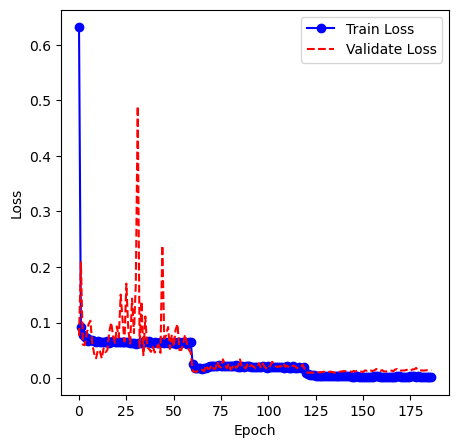

 94%|█████████████████████████████████████████████████████████████████████▏    | 187/200 [23:50:18<1:48:59, 503.01s/it]

Epoch:187
Time:23:58:02.630318
Loss:0.014357906576642505
Total:10000  Correct:9964  CleanAccuracy:0.9964


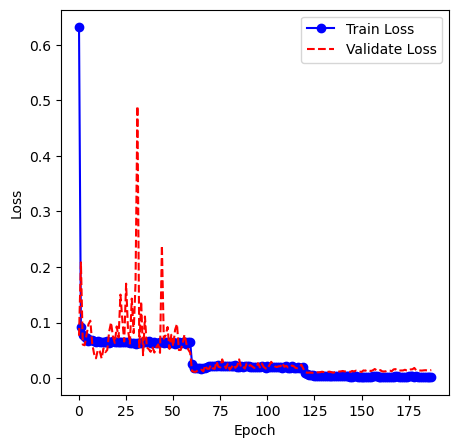

 94%|█████████████████████████████████████████████████████████████████████▌    | 188/200 [23:58:35<1:40:15, 501.29s/it]

Epoch:188
Time:1 day, 0:06:24.013132
Loss:0.013473779864563865
Total:10000  Correct:9967  CleanAccuracy:0.9967


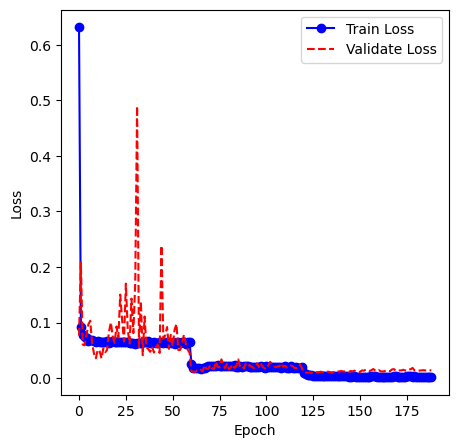

 94%|█████████████████████████████████████████████████████████████████████▉    | 189/200 [24:06:49<1:31:29, 499.04s/it]

Epoch:189
Time:1 day, 0:14:37.952213
Loss:0.013608250686096938
Total:10000  Correct:9966  CleanAccuracy:0.9966


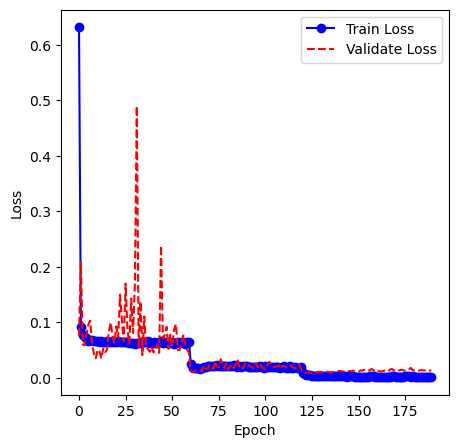

 95%|██████████████████████████████████████████████████████████████████████▎   | 190/200 [24:15:06<1:23:03, 498.35s/it]

Epoch:190
Time:1 day, 0:22:56.783952
Loss:0.013461052578094358
Total:10000  Correct:9967  CleanAccuracy:0.9967


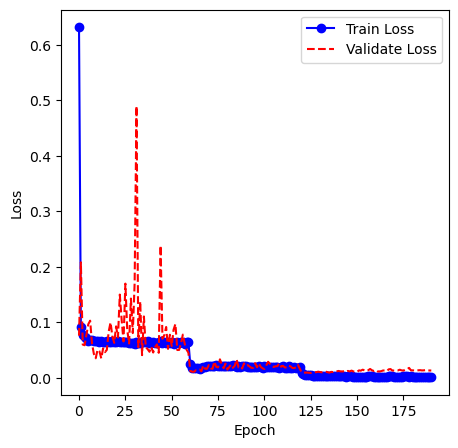

 96%|██████████████████████████████████████████████████████████████████████▋   | 191/200 [24:23:31<1:15:03, 500.40s/it]

Epoch:191
Time:1 day, 0:31:19.123728
Loss:0.013216131332664402
Total:10000  Correct:9971  CleanAccuracy:0.9971


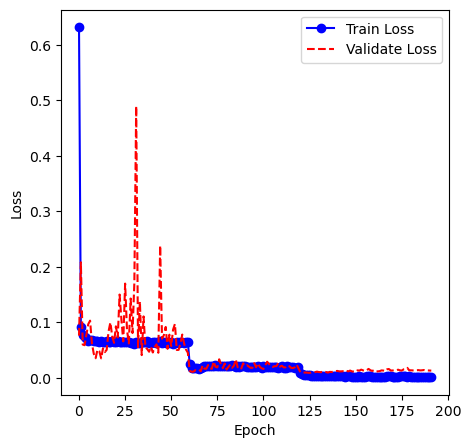

 96%|███████████████████████████████████████████████████████████████████████   | 192/200 [24:31:58<1:06:58, 502.37s/it]

Epoch:192
Time:1 day, 0:39:50.907075
Loss:0.013135892950045242
Total:10000  Correct:9968  CleanAccuracy:0.9968


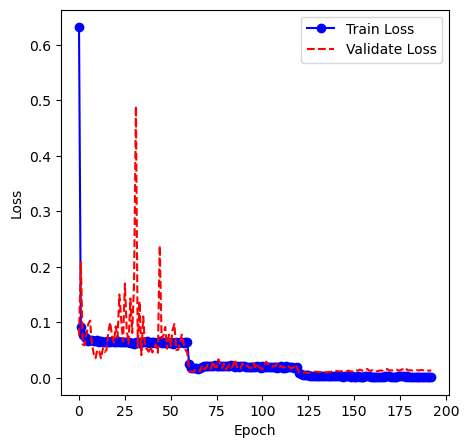

 96%|█████████████████████████████████████████████████████████████████████████▎  | 193/200 [24:40:28<58:52, 504.68s/it]

Epoch:193
Time:1 day, 0:48:18.060068
Loss:0.013334484441360584
Total:10000  Correct:9968  CleanAccuracy:0.9968


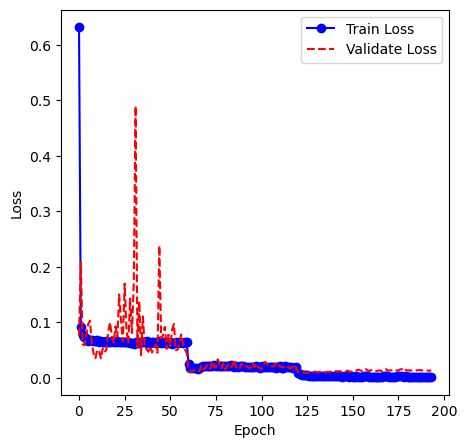

 97%|█████████████████████████████████████████████████████████████████████████▋  | 194/200 [24:48:53<50:29, 504.95s/it]

Epoch:194
Time:1 day, 0:56:55.988863
Loss:0.014052123842539992
Total:10000  Correct:9966  CleanAccuracy:0.9966


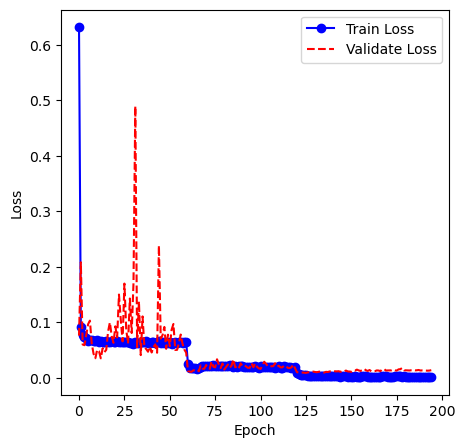

 98%|██████████████████████████████████████████████████████████████████████████  | 195/200 [24:57:33<42:27, 509.46s/it]

Epoch:195
Time:1 day, 1:05:33.792541
Loss:0.014029269221241767
Total:10000  Correct:9968  CleanAccuracy:0.9968


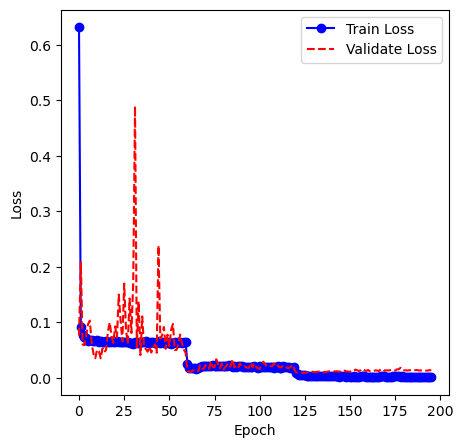

 98%|██████████████████████████████████████████████████████████████████████████▍ | 196/200 [25:06:12<34:08, 512.06s/it]

Epoch:196
Time:1 day, 1:14:24.053349
Loss:0.013987364241676317
Total:10000  Correct:9967  CleanAccuracy:0.9967


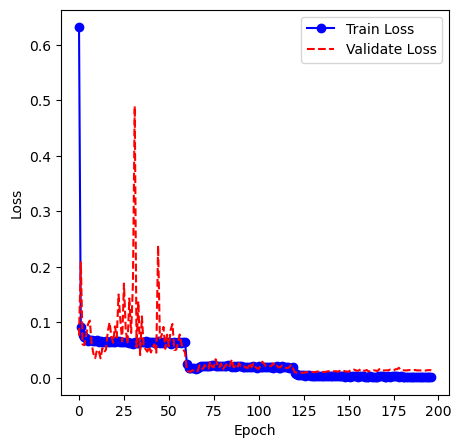

 98%|██████████████████████████████████████████████████████████████████████████▊ | 197/200 [25:15:02<25:52, 517.47s/it]

Epoch:197
Time:1 day, 1:23:08.212313
Loss:0.01358338528738235
Total:10000  Correct:9967  CleanAccuracy:0.9967


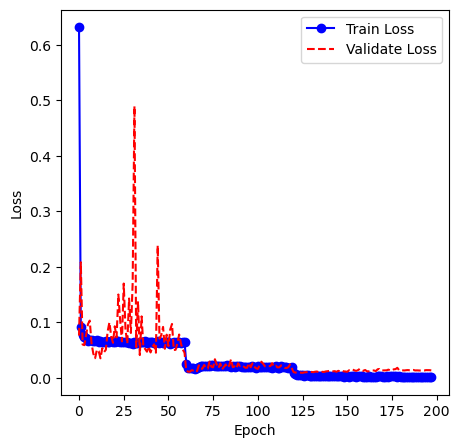

 99%|███████████████████████████████████████████████████████████████████████████▏| 198/200 [25:23:45<17:18, 519.15s/it]

Epoch:198
Time:1 day, 1:31:58.841929
Loss:0.013605060174870795
Total:10000  Correct:9967  CleanAccuracy:0.9967


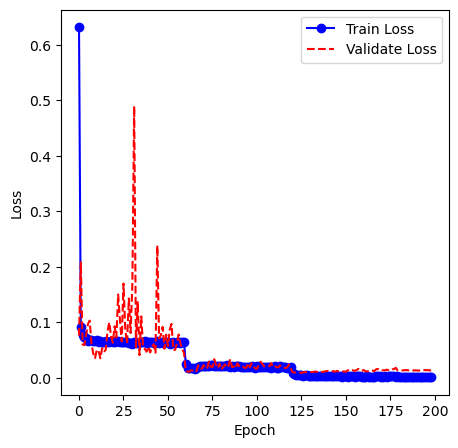

100%|███████████████████████████████████████████████████████████████████████████▌| 199/200 [25:32:37<08:43, 523.02s/it]

Epoch:199
Time:1 day, 1:40:44.195439
Loss:0.013417213350704041
Total:10000  Correct:9968  CleanAccuracy:0.9968


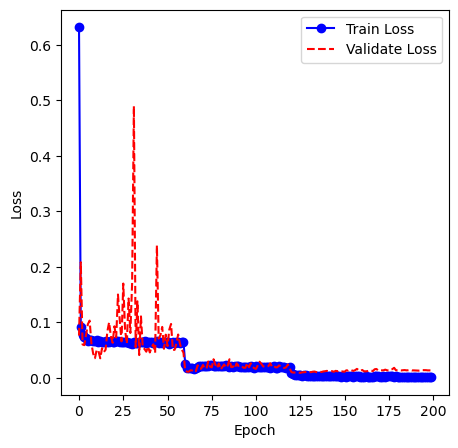

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [25:41:21<00:00, 462.41s/it]


In [9]:
train(model_device=device,
      model=net,
      model_optimizer=optimizer, 
      train_set=train_loader, 
      validate_set=test_loader
)

In [10]:
torch.cuda.empty_cache()